# Artificial Neural Networks - Réseaux de neurones artificiels

###### Objectifs: 
Prédire pour une Banque le type de client succeptible de les quitter. C'est à dire le segment de client qui a plus tendance à quitter la banque que les autres.

In [23]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prétraitement des données,  Data Preprocessing

In [24]:
# Lire les données
dataset = pd.read_csv('./data/Churn_Modelling.csv')

In [25]:
dataset.shape

(10000, 14)

In [26]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Description Variables:
CustomerId: identifiant client; Surname: Nom du client; CreditScore: Capacité de remboursement d'un client. Plus ce score est élévé plus le client est succeptible de rembourser le credit; Geography: pays d'origine du client; Gender; Age; tenure: nombre d'années du client dans la banque; Balance: solde du client au moment de l'enquete; NumOfProducts: services proposés par la banque auxquels le client a souscrit( carte de credit, credit, soucription...etc); HasCrCard: Le client possède une carte de crédit ou pas ?; IsActiveMember: Le client est un membre actif ou non; EstimatedSalary: Estimation du salaire d'un client; Exited: variable à predire: Le client est resté ou pas.

In [27]:
# Verifications des données manquantes
dataset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Pas de variables manquantes

In [28]:
# Matrice des variables independantes
X = dataset.iloc[:, 3:13]

# Matrice de la variable dependante
y = dataset.iloc[:, 13]

On selectionne les variables pertinantes. Les variables pouvant influencer sur le model. On supprime: RowNumber, CustumerId, Surname jugées moins pertinentes

In [29]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


Les variables categorielles ne sont pas ordinales. On ne peut pas les classées. Par exemple avec la colonne X[pays] nous auront 3valeurs categoriel -> 0, 1, 2. Ce qui peut fausser l'interpretation. En effet 2 etant >1 , le modele considerera que 2(spain) est plus grand que 1(Germany). Ce qui n'est pas forcement le cas. Utilisons OneHotEncoder pour les coder afin de resoudre ce problème.

In [30]:
# Encodage des variables catégoriques et mise à l'échelle des variables continues
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

preprocess = make_column_transformer(
        (OneHotEncoder(), ['Geography', 'Gender']),
        (StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance',
                            'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                            'EstimatedSalary']))

X = preprocess.fit_transform(X)

In [31]:
X

array([[ 1.        ,  0.        ,  0.        , ...,  0.64609167,
         0.97024255,  0.02188649],
       [ 0.        ,  0.        ,  1.        , ..., -1.54776799,
         0.97024255,  0.21653375],
       [ 1.        ,  0.        ,  0.        , ...,  0.64609167,
        -1.03067011,  0.2406869 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.54776799,
         0.97024255, -1.00864308],
       [ 0.        ,  1.        ,  0.        , ...,  0.64609167,
        -1.03067011, -0.12523071],
       [ 1.        ,  0.        ,  0.        , ...,  0.64609167,
        -1.03067011, -1.07636976]])

In [32]:
# Il faut supprimer une colonne après transformation du OneHotEncoder car deux colonnes sont suffisant pour coder 3 categories
X = np.delete(X, [0,3], 1)

In [34]:
# Variable independante
from sklearn.preprocessing import LabelEncoder

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [35]:
# Diviser les données en train(données d'entrainement) et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Constuction du modèle

In [37]:
# Importation des bibliothèques et packages Keras
from keras.models import Sequential
from keras.layers import Dense

In [38]:
# Initialisation de l'ANN
classifier = Sequential()

# Ajout de la couche d'entrée et de la première couche cachée

# Nombre de neurone de la couche d'entrée est à determiner après experimentations. 
# La couche d'entrée se crée automatiquement 
# Astuce: nombre colonnes X + nombre colonnes Y / 2

classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Ajout de la deuxieme couche cachée
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Ajout de la couche de sortie
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compilation du modèle
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Entrainer Model

In [39]:
# Entrainer le modèle
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
8000/8000 [==============================] - 1s 166us/step - loss: 0.4932 - accuracy: 0.7952
Epoch 2/100
8000/8000 [==============================] - 1s 151us/step - loss: 0.4179 - accuracy: 0.8199
Epoch 3/100
8000/8000 [==============================] - 1s 168us/step - loss: 0.4000 - accuracy: 0.8263
Epoch 4/100
8000/8000 [==============================] - 1s 150us/step - loss: 0.3893 - accuracy: 0.8282
Epoch 5/100
8000/8000 [==============================] - 1s 149us/step - loss: 0.3816 - accuracy: 0.8305
Epoch 6/100
8000/8000 [==============================] - 1s 160us/step - loss: 0.3759 - accuracy: 0.8304
Epoch 7/100
8000/8000 [==============================] - 1s 150us/step - loss: 0.3730 - accuracy: 0.8451
Epoch 8/100
8000/8000 [==============================] - 1s 148us/step - loss: 0.3695 - accuracy: 0.8474
Epoch 9/100
8000/8000 [==============================] - 1s 150us/step - loss: 0.3668 - accuracy: 0.8526
Epoch 10/100
8000/8000 [==============================]

Accuracy = 86%

loss= 0,33

### Prediction

In [41]:
# Prédiction sur les données de Test
y_pred = classifier.predict(X_test)
print("Probalibité d'appartenance à une classe:\n", y_pred[0:6])

# Seuil de classification car a la sortie nous avons une probabilité
y_pred = (y_pred > 0.5)
print("Classification en fonction du seuil:\n", y_pred[0:6])

Probalibité d'appartenance à une classe:
 [[0.2408553 ]
 [0.2416231 ]
 [0.07662308]
 [0.063723  ]
 [0.04940295]
 [0.90457326]]
Classification en fonction du seuil:
 [[False]
 [False]
 [False]
 [False]
 [False]
 [ True]]


### Evaluation

In [ ]:
# Matrix de Confusion
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

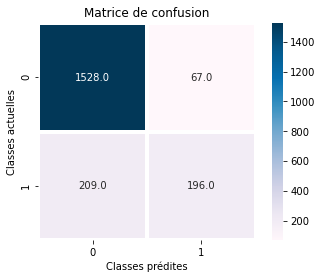

In [47]:
# Visualisation avec Seaborn

import seaborn as sns

sns.heatmap(cm, annot=True, fmt=".1f", linewidths=3, square=True, cmap='PuBu', color="#cd1076")
plt.ylabel('Classes actuelles')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion', size=12)
plt.show()

In [64]:
# Précision sur le jeu de test (TP + TN) / TP + TN + FP + FN
p = (1538 + 196) / 2000
p

0.867

La précision sur les données d'entrainement et sur les données de test sont comparables. Le modèle pourra donc se généraliser sur de nouvelles observations.

### Prediction sur une  nouvelle observation

In [49]:
# Prédiction sur une nouvelle observation
"""Predict if the customer with the following informations will leave the bank:
Geography: France
Credit Score: 600
Gender: Male
Age: 40
Tenure: 3
Balance: 60000
Number of Products: 2
Has Credit Card: Yes
Is Active Member: Yes
Estimated Salary: 50000"""


Xnew = pd.DataFrame(data={
        'CreditScore': [600], 
        'Geography': ['France'], 
        'Gender': ['Male'],
        'Age': [40],
        'Tenure': [3],
        'Balance': [60000],
        'NumOfProducts': [2],
        'HasCrCard': [1],
        'IsActiveMember': [1],
        'EstimatedSalary': [50000]})

# Même transformation : Coder les données catégoriques et mettre à l'échelle les données continues
Xnew = preprocess.transform(Xnew)
Xnew = np.delete(Xnew, [0,3], 1)

# Classification
new_prediction = classifier.predict(Xnew)
new_prediction = (new_prediction > 0.5)
print(new_prediction)

[[False]]


## Evaluation du modèle: K-Fold Cross Validation

Resoudre le problème de Bias- Variance

Objectifs: Bias et variance faible

In [51]:
#Comibner le modèle de ANN de (Keras) et l'algo k-fold (scikit-learn)

from keras.wrappers.scikit_learn import KerasClassifier # pont entre keras et scikit
from sklearn.model_selection import cross_val_score

def build_classifier():
'''
Fonction pour constuire et compiler l'ANN
'''
    classifier = Sequential()

    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return classifier

# Creation modèle
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)

# validation croisée K-Fold k = 10
precisions = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

Epoch 1/100
7200/7200 [==============================] - 1s 176us/step - loss: 0.4935 - accuracy: 0.7958
Epoch 2/100
7200/7200 [==============================] - 1s 149us/step - loss: 0.4326 - accuracy: 0.7971
Epoch 3/100
7200/7200 [==============================] - 1s 149us/step - loss: 0.4273 - accuracy: 0.7971
Epoch 4/100
7200/7200 [==============================] - 1s 151us/step - loss: 0.4222 - accuracy: 0.7979
Epoch 5/100
7200/7200 [==============================] - 1s 147us/step - loss: 0.4183 - accuracy: 0.8239
Epoch 6/100
7200/7200 [==============================] - 1s 147us/step - loss: 0.4160 - accuracy: 0.8269
Epoch 7/100
7200/7200 [==============================] - 1s 178us/step - loss: 0.4144 - accuracy: 0.8313
Epoch 8/100
7200/7200 [==============================] - 2s 228us/step - loss: 0.4126 - accuracy: 0.8329
Epoch 9/100
7200/7200 [==============================] - 1s 130us/step - loss: 0.4122 - accuracy: 0.8318
Epoch 10/100
7200/7200 [==============================]

Epoch 55/100
7200/7200 [==============================] - 3s 366us/step - loss: 0.3525 - accuracy: 0.8586
Epoch 56/100
7200/7200 [==============================] - 3s 470us/step - loss: 0.3512 - accuracy: 0.8585
Epoch 57/100
7200/7200 [==============================] - 3s 471us/step - loss: 0.3494 - accuracy: 0.8592
Epoch 58/100
7200/7200 [==============================] - 3s 466us/step - loss: 0.3488 - accuracy: 0.8606
Epoch 59/100
7200/7200 [==============================] - 3s 439us/step - loss: 0.3487 - accuracy: 0.8597
Epoch 60/100
7200/7200 [==============================] - 3s 447us/step - loss: 0.3469 - accuracy: 0.8594
Epoch 61/100
7200/7200 [==============================] - 3s 458us/step - loss: 0.3464 - accuracy: 0.8607
Epoch 62/100
7200/7200 [==============================] - 3s 451us/step - loss: 0.3457 - accuracy: 0.8610
Epoch 63/100
7200/7200 [==============================] - 3s 460us/step - loss: 0.3454 - accuracy: 0.8611
Epoch 64/100
7200/7200 [======================

7200/7200 [==============================] - 1s 126us/step - loss: 0.4118 - accuracy: 0.8324
Epoch 8/100
7200/7200 [==============================] - 1s 124us/step - loss: 0.4104 - accuracy: 0.8315
Epoch 9/100
7200/7200 [==============================] - 1s 127us/step - loss: 0.4097 - accuracy: 0.8336
Epoch 10/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.4088 - accuracy: 0.8346
Epoch 11/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.4074 - accuracy: 0.8346
Epoch 12/100
7200/7200 [==============================] - 1s 124us/step - loss: 0.4069 - accuracy: 0.8340
Epoch 13/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.4061 - accuracy: 0.8351
Epoch 14/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.4057 - accuracy: 0.8360
Epoch 15/100
7200/7200 [==============================] - 1s 126us/step - loss: 0.4051 - accuracy: 0.8371
Epoch 16/100
7200/7200 [==============================] - 1s 

Epoch 61/100
7200/7200 [==============================] - 1s 127us/step - loss: 0.3434 - accuracy: 0.8590
Epoch 62/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.3437 - accuracy: 0.8586
Epoch 63/100
7200/7200 [==============================] - 1s 172us/step - loss: 0.3428 - accuracy: 0.8603
Epoch 64/100
7200/7200 [==============================] - 1s 127us/step - loss: 0.3442 - accuracy: 0.8574
Epoch 65/100
7200/7200 [==============================] - 1s 126us/step - loss: 0.3433 - accuracy: 0.8572
Epoch 66/100
7200/7200 [==============================] - 1s 126us/step - loss: 0.3437 - accuracy: 0.8589
Epoch 67/100
7200/7200 [==============================] - 1s 171us/step - loss: 0.3428 - accuracy: 0.8586
Epoch 68/100
7200/7200 [==============================] - 1s 126us/step - loss: 0.3439 - accuracy: 0.8585
Epoch 69/100
7200/7200 [==============================] - 1s 125us/step - loss: 0.3437 - accuracy: 0.8601
Epoch 70/100
7200/7200 [======================

Epoch 14/100
7200/7200 [==============================] - 1s 131us/step - loss: 0.3991 - accuracy: 0.8344
Epoch 15/100
7200/7200 [==============================] - 1s 155us/step - loss: 0.3989 - accuracy: 0.8331
Epoch 16/100
7200/7200 [==============================] - 1s 154us/step - loss: 0.3985 - accuracy: 0.8347
Epoch 17/100
7200/7200 [==============================] - 1s 132us/step - loss: 0.3983 - accuracy: 0.8338
Epoch 18/100
7200/7200 [==============================] - 1s 132us/step - loss: 0.3978 - accuracy: 0.8349
Epoch 19/100
7200/7200 [==============================] - 1s 163us/step - loss: 0.3978 - accuracy: 0.8346
Epoch 20/100
7200/7200 [==============================] - 1s 144us/step - loss: 0.3975 - accuracy: 0.8343
Epoch 21/100
7200/7200 [==============================] - 1s 178us/step - loss: 0.3969 - accuracy: 0.8346
Epoch 22/100
7200/7200 [==============================] - 1s 131us/step - loss: 0.3972 - accuracy: 0.8350
Epoch 23/100
7200/7200 [======================

Epoch 68/100
7200/7200 [==============================] - 1s 134us/step - loss: 0.3445 - accuracy: 0.8619
Epoch 69/100
7200/7200 [==============================] - 1s 136us/step - loss: 0.3445 - accuracy: 0.8621
Epoch 70/100
7200/7200 [==============================] - 1s 144us/step - loss: 0.3453 - accuracy: 0.8611
Epoch 71/100
7200/7200 [==============================] - 1s 135us/step - loss: 0.3444 - accuracy: 0.8635
Epoch 72/100
7200/7200 [==============================] - 1s 180us/step - loss: 0.3441 - accuracy: 0.8614
Epoch 73/100
7200/7200 [==============================] - 1s 136us/step - loss: 0.3436 - accuracy: 0.8635
Epoch 74/100
7200/7200 [==============================] - 1s 136us/step - loss: 0.3430 - accuracy: 0.8604
Epoch 75/100
7200/7200 [==============================] - 1s 135us/step - loss: 0.3445 - accuracy: 0.8626
Epoch 76/100
7200/7200 [==============================] - 1s 139us/step - loss: 0.3437 - accuracy: 0.8601
Epoch 77/100
7200/7200 [======================

Epoch 21/100
7200/7200 [==============================] - 1s 141us/step - loss: 0.4072 - accuracy: 0.8339
Epoch 22/100
7200/7200 [==============================] - 1s 140us/step - loss: 0.4069 - accuracy: 0.8342
Epoch 23/100
7200/7200 [==============================] - 1s 141us/step - loss: 0.4071 - accuracy: 0.8344
Epoch 24/100
7200/7200 [==============================] - 1s 171us/step - loss: 0.4061 - accuracy: 0.8324
Epoch 25/100
7200/7200 [==============================] - 1s 160us/step - loss: 0.4063 - accuracy: 0.8331
Epoch 26/100
7200/7200 [==============================] - 1s 190us/step - loss: 0.4059 - accuracy: 0.8340
Epoch 27/100
7200/7200 [==============================] - 1s 141us/step - loss: 0.4058 - accuracy: 0.8328
Epoch 28/100
7200/7200 [==============================] - 1s 142us/step - loss: 0.4055 - accuracy: 0.8338
Epoch 29/100
7200/7200 [==============================] - 1s 143us/step - loss: 0.4054 - accuracy: 0.8328
Epoch 30/100
7200/7200 [======================

In [54]:
# Moyenne Précision
moyenne = precisions.mean()
print("Precision Moyenne: ", moyenne)

# Ecart type precision
std = precisions.std()
print("Ecart type: ", std)

Precision Moyenne:  0.8426250040531158
Ecart type:  0.014816060630179663


La variance est faible 1,7 %. Le modèle peut donc se généraliser facilement sur de nouveaux ensemble. Pas de problème de sur-entrainement.

## Amelioration du Modèle: Comment éviter le sur-entrainement -> Dropout

Ajouter une couche Dropout qpres chaque neurone pour éviter que les neurones soient trop dependants entre eux

In [58]:
from keras.layers import Dropout

In [60]:
classifier = Sequential()

classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Ajout couche Dropout. rate = 0.1 -> 10% des neurones seront desactivés
classifier.add(Dropout(rate = 0.1))

# 2nd couche cachée
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

classifier.add(Dropout(rate = 0.1))

# couche de sortie
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# compiler le modèle
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
# Entrainement
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
8000/8000 [==============================] - 3s 348us/step - loss: 0.4992 - accuracy: 0.7960
Epoch 2/100
8000/8000 [==============================] - 2s 201us/step - loss: 0.4452 - accuracy: 0.7960
Epoch 3/100
8000/8000 [==============================] - 2s 288us/step - loss: 0.4406 - accuracy: 0.7960
Epoch 4/100
8000/8000 [==============================] - 2s 252us/step - loss: 0.4365 - accuracy: 0.7960
Epoch 5/100
8000/8000 [==============================] - 2s 259us/step - loss: 0.4320 - accuracy: 0.7960
Epoch 6/100
8000/8000 [==============================] - 2s 225us/step - loss: 0.4324 - accuracy: 0.7960
Epoch 7/100
8000/8000 [==============================] - 2s 218us/step - loss: 0.4312 - accuracy: 0.7960
Epoch 8/100
8000/8000 [==============================] - 2s 221us/step - loss: 0.4275 - accuracy: 0.7960
Epoch 9/100
8000/8000 [==============================] - 2s 202us/step - loss: 0.4294 - accuracy: 0.7960
Epoch 10/100
8000/8000 [==============================]

In [62]:
# Résultat de prédiction sur le jeu de test
y_pred = classifier.predict(X_test)
print("Probalibité d'appartenance à une classe:\n", y_pred[0:6])

# Seuil de classification car à la sortie nous avons une probabilité
y_pred = (y_pred > 0.5)
print("Classification en fonction du seuil:\n", y_pred[0:6])

Probalibité d'appartenance à une classe:
 [[0.2604543 ]
 [0.3385909 ]
 [0.24105275]
 [0.06882495]
 [0.19408336]
 [0.54402375]]
Classification en fonction du seuil:
 [[False]
 [False]
 [False]
 [False]
 [False]
 [ True]]


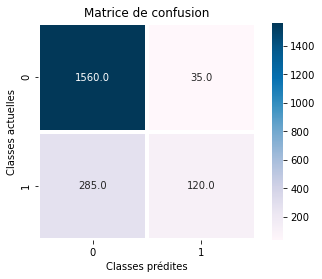

In [63]:
# Evaluation
import seaborn as sns

# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=3, square=True, cmap='PuBu', color="#cd1076")
plt.ylabel('Classes actuelles')
plt.xlabel('Classes prédites')
plt.title('Matrice de confusion', size=12)
plt.show()

In [65]:
p = (1560 + 120) / 2000
p

0.84

## Ajuster le Modèle, Optimiser les hyper-parametres: Grid-search 

Optimiser les hyper-parametres pour obtenir la meilleure combinaison possible

In [73]:
from sklearn.model_selection import GridSearchCV

In [75]:
def build_classifier(optimizer):
    # Initialising the ANN
    classifier = Sequential()

    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [76]:
# Creation modèle
classifier = KerasClassifier(build_fn = build_classifier)

In [77]:
# Les paramètres à optimiser

parameters = {"batch_size": [25, 32],
              "epochs": [200, 500],
              "optimizer": ["adam", "rmsprop"]}

2* 2 * 2 = 8 combinaisons à tester

In [78]:
# Grid_search Utilise la methode K-fold cross validation pour l'evaluation
grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                           scoring = "accuracy",
                          cv=10) 

In [79]:
# Entrainer le modèle
grid_search = grid_search.fit(X_train, y_train)

Epoch 1/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.5526 - accuracy: 0.7968
Epoch 2/200
7200/7200 [==============================] - 1s 82us/step - loss: 0.4405 - accuracy: 0.7971
Epoch 3/200
7200/7200 [==============================] - 1s 80us/step - loss: 0.4329 - accuracy: 0.7971
Epoch 4/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.4285 - accuracy: 0.7971
Epoch 5/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.4250 - accuracy: 0.7971
Epoch 6/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.4218 - accuracy: 0.7971
Epoch 7/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.4190 - accuracy: 0.8108
Epoch 8/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.4171 - accuracy: 0.8256
Epoch 9/200
7200/7200 [==============================] - 1s 80us/step - loss: 0.4160 - accuracy: 0.8247
Epoch 10/200
7200/7200 [==============================] - 1s 8

7200/7200 [==============================] - 1s 79us/step - loss: 0.4011 - accuracy: 0.8349
Epoch 80/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.4013 - accuracy: 0.8361
Epoch 81/200
7200/7200 [==============================] - 1s 77us/step - loss: 0.4009 - accuracy: 0.8343
Epoch 82/200
7200/7200 [==============================] - 1s 78us/step - loss: 0.4009 - accuracy: 0.8358
Epoch 83/200
7200/7200 [==============================] - 1s 78us/step - loss: 0.4010 - accuracy: 0.8340
Epoch 84/200
7200/7200 [==============================] - 1s 77us/step - loss: 0.4010 - accuracy: 0.8347
Epoch 85/200
7200/7200 [==============================] - 1s 78us/step - loss: 0.4009 - accuracy: 0.8346
Epoch 86/200
7200/7200 [==============================] - 1s 80us/step - loss: 0.4008 - accuracy: 0.8361
Epoch 87/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.4008 - accuracy: 0.8363
Epoch 88/200
7200/7200 [==============================] - 1s 80us/st

7200/7200 [==============================] - 1s 80us/step - loss: 0.4038 - accuracy: 0.8350
Epoch 34/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4035 - accuracy: 0.8350
Epoch 35/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.4034 - accuracy: 0.8349
Epoch 36/200
7200/7200 [==============================] - 1s 78us/step - loss: 0.4032 - accuracy: 0.8346
Epoch 37/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4031 - accuracy: 0.8350
Epoch 38/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.4030 - accuracy: 0.8346
Epoch 39/200
7200/7200 [==============================] - 1s 77us/step - loss: 0.4024 - accuracy: 0.8340
Epoch 40/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4022 - accuracy: 0.8340
Epoch 41/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.4028 - accuracy: 0.8363
Epoch 42/200
7200/7200 [==============================] - 1s 78us

7200/7200 [==============================] - 1s 79us/step - loss: 0.3987 - accuracy: 0.8361
Epoch 188/200
7200/7200 [==============================] - 1s 110us/step - loss: 0.3992 - accuracy: 0.8375
Epoch 189/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3989 - accuracy: 0.8378
Epoch 190/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.3993 - accuracy: 0.8368
Epoch 191/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.3993 - accuracy: 0.8363
Epoch 192/200
7200/7200 [==============================] - 1s 97us/step - loss: 0.3990 - accuracy: 0.8358
Epoch 193/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.3990 - accuracy: 0.8367
Epoch 194/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3989 - accuracy: 0.8372
Epoch 195/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.3989 - accuracy: 0.8369
Epoch 196/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 80us/step - loss: 0.4005 - accuracy: 0.8346
Epoch 142/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.4001 - accuracy: 0.8358
Epoch 143/200
7200/7200 [==============================] - 1s 79us/step - loss: 0.4003 - accuracy: 0.8343
Epoch 144/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.4002 - accuracy: 0.8357
Epoch 145/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.4002 - accuracy: 0.8350
Epoch 146/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.4005 - accuracy: 0.8361
Epoch 147/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.4001 - accuracy: 0.8357
Epoch 148/200
7200/7200 [==============================] - 1s 80us/step - loss: 0.3999 - accuracy: 0.8365
Epoch 149/200
7200/7200 [==============================] - 1s 81us/step - loss: 0.3999 - accuracy: 0.8363
Epoch 150/200
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 109us/step - loss: 0.3397 - accuracy: 0.8604
Epoch 96/200
7200/7200 [==============================] - 1s 97us/step - loss: 0.3411 - accuracy: 0.8596
Epoch 97/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3410 - accuracy: 0.8586
Epoch 98/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3413 - accuracy: 0.8610
Epoch 99/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3422 - accuracy: 0.8568
Epoch 100/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.3396 - accuracy: 0.8594
Epoch 101/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3415 - accuracy: 0.8596
Epoch 102/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.3413 - accuracy: 0.8592
Epoch 103/200
7200/7200 [==============================] - 1s 82us/step - loss: 0.3403 - accuracy: 0.8596
Epoch 104/200
7200/7200 [==============================] - 1s

7200/7200 [==============================] - 1s 91us/step - loss: 0.4057 - accuracy: 0.8326
Epoch 50/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.4061 - accuracy: 0.8340
Epoch 51/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.4058 - accuracy: 0.8328
Epoch 52/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.4058 - accuracy: 0.8349
Epoch 53/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.4054 - accuracy: 0.8335
Epoch 54/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.4056 - accuracy: 0.8331
Epoch 55/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.4053 - accuracy: 0.8342
Epoch 56/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.4055 - accuracy: 0.8331
Epoch 57/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.4051 - accuracy: 0.8336
Epoch 58/200
7200/7200 [==============================] - 1s 83us/

7200/7200 [==============================] - 1s 92us/step - loss: 0.4215 - accuracy: 0.7944
Epoch 4/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.4139 - accuracy: 0.7944
Epoch 5/200
7200/7200 [==============================] - 1s 81us/step - loss: 0.4069 - accuracy: 0.7944
Epoch 6/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.4009 - accuracy: 0.8174
Epoch 7/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3958 - accuracy: 0.8274
Epoch 8/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.3913 - accuracy: 0.8285
Epoch 9/200
7200/7200 [==============================] - 1s 84us/step - loss: 0.3866 - accuracy: 0.8299
Epoch 10/200
7200/7200 [==============================] - 1s 82us/step - loss: 0.3831 - accuracy: 0.8296
Epoch 11/200
7200/7200 [==============================] - 1s 106us/step - loss: 0.3795 - accuracy: 0.8413
Epoch 12/200
7200/7200 [==============================] - 1s 108us/step -

7200/7200 [==============================] - 1s 107us/step - loss: 0.3443 - accuracy: 0.8611
Epoch 158/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3451 - accuracy: 0.8610
Epoch 159/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.3443 - accuracy: 0.8607
Epoch 160/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3435 - accuracy: 0.8607
Epoch 161/200
7200/7200 [==============================] - 1s 101us/step - loss: 0.3448 - accuracy: 0.8593
Epoch 162/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.3446 - accuracy: 0.8599
Epoch 163/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3441 - accuracy: 0.8607
Epoch 164/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3444 - accuracy: 0.8599
Epoch 165/200
7200/7200 [==============================] - 1s 83us/step - loss: 0.3450 - accuracy: 0.8585
Epoch 166/200
7200/7200 [==============================

7200/7200 [==============================] - 1s 86us/step - loss: 0.4010 - accuracy: 0.8363
Epoch 112/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.4010 - accuracy: 0.8358
Epoch 113/200
7200/7200 [==============================] - 1s 124us/step - loss: 0.4008 - accuracy: 0.8353
Epoch 114/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.4012 - accuracy: 0.8354
Epoch 115/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.4008 - accuracy: 0.8358
Epoch 116/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.4009 - accuracy: 0.8360
Epoch 117/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4010 - accuracy: 0.8349
Epoch 118/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.4009 - accuracy: 0.8350
Epoch 119/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.4013 - accuracy: 0.8353
Epoch 120/200
7200/7200 [==============================] -

7200/7200 [==============================] - 1s 86us/step - loss: 0.3997 - accuracy: 0.8347
Epoch 189/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.3999 - accuracy: 0.8360
Epoch 190/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3995 - accuracy: 0.8363
Epoch 191/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3998 - accuracy: 0.8356
Epoch 192/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.3998 - accuracy: 0.8368
Epoch 193/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.4000 - accuracy: 0.8351
Epoch 194/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4002 - accuracy: 0.8354
Epoch 195/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.3998 - accuracy: 0.8365
Epoch 196/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.4001 - accuracy: 0.8353
Epoch 197/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 92us/step - loss: 0.3382 - accuracy: 0.8608
Epoch 143/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3379 - accuracy: 0.8626
Epoch 144/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3380 - accuracy: 0.8618
Epoch 145/200
7200/7200 [==============================] - 1s 110us/step - loss: 0.3374 - accuracy: 0.8604
Epoch 146/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.3379 - accuracy: 0.8607
Epoch 147/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3380 - accuracy: 0.8604
Epoch 148/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3375 - accuracy: 0.8632
Epoch 149/200
7200/7200 [==============================] - 1s 101us/step - loss: 0.3376 - accuracy: 0.8603
Epoch 150/200
7200/7200 [==============================] - 1s 126us/step - loss: 0.3372 - accuracy: 0.8608
Epoch 151/200
7200/7200 [=============================

7200/7200 [==============================] - 1s 91us/step - loss: 0.3915 - accuracy: 0.8371
Epoch 97/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3914 - accuracy: 0.8360
Epoch 98/200
7200/7200 [==============================] - 1s 100us/step - loss: 0.3911 - accuracy: 0.8385
Epoch 99/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3911 - accuracy: 0.8378
Epoch 100/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3913 - accuracy: 0.8378
Epoch 101/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3911 - accuracy: 0.8374
Epoch 102/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.3912 - accuracy: 0.8369
Epoch 103/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3909 - accuracy: 0.8385
Epoch 104/200
7200/7200 [==============================] - 1s 126us/step - loss: 0.3909 - accuracy: 0.8382
Epoch 105/200
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 106us/step - loss: 0.3899 - accuracy: 0.8400
Epoch 174/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3900 - accuracy: 0.8379
Epoch 175/200
7200/7200 [==============================] - 1s 86us/step - loss: 0.3895 - accuracy: 0.8386
Epoch 176/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3897 - accuracy: 0.8390
Epoch 177/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.3897 - accuracy: 0.8386
Epoch 178/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3898 - accuracy: 0.8386
Epoch 179/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3895 - accuracy: 0.8381
Epoch 180/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3896 - accuracy: 0.8382
Epoch 181/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3895 - accuracy: 0.8394
Epoch 182/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 120us/step - loss: 0.4023 - accuracy: 0.8336
Epoch 128/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4021 - accuracy: 0.8324
Epoch 129/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4020 - accuracy: 0.8353
Epoch 130/200
7200/7200 [==============================] - 1s 133us/step - loss: 0.4023 - accuracy: 0.8332
Epoch 131/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.4023 - accuracy: 0.8335
Epoch 132/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.4022 - accuracy: 0.8343
Epoch 133/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.4021 - accuracy: 0.8335
Epoch 134/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.4021 - accuracy: 0.8338
Epoch 135/200
7200/7200 [==============================] - 1s 97us/step - loss: 0.4019 - accuracy: 0.8349
Epoch 136/200
7200/7200 [==============================]

7200/7200 [==============================] - 1s 91us/step - loss: 0.4929 - accuracy: 0.8131
Epoch 5/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.4509 - accuracy: 0.8418
Epoch 6/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.4133 - accuracy: 0.8501
Epoch 7/200
7200/7200 [==============================] - 1s 87us/step - loss: 0.3823 - accuracy: 0.8519
Epoch 8/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.3654 - accuracy: 0.8531
Epoch 9/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3564 - accuracy: 0.8601
Epoch 10/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.3522 - accuracy: 0.8592
Epoch 11/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3497 - accuracy: 0.8590
Epoch 12/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3482 - accuracy: 0.8608
Epoch 13/200
7200/7200 [==============================] - 1s 109us/step -

7200/7200 [==============================] - 1s 113us/step - loss: 0.3321 - accuracy: 0.8653
Epoch 159/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3317 - accuracy: 0.8651
Epoch 160/200
7200/7200 [==============================] - 1s 125us/step - loss: 0.3316 - accuracy: 0.8657
Epoch 161/200
7200/7200 [==============================] - 1s 97us/step - loss: 0.3313 - accuracy: 0.8656
Epoch 162/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3316 - accuracy: 0.8660
Epoch 163/200
7200/7200 [==============================] - 1s 85us/step - loss: 0.3321 - accuracy: 0.8649
Epoch 164/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3314 - accuracy: 0.8667
Epoch 165/200
7200/7200 [==============================] - 1s 99us/step - loss: 0.3315 - accuracy: 0.8660
Epoch 166/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.3316 - accuracy: 0.8636
Epoch 167/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 102us/step - loss: 0.3964 - accuracy: 0.8358
Epoch 113/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3965 - accuracy: 0.8368
Epoch 114/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3966 - accuracy: 0.8357
Epoch 115/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.3961 - accuracy: 0.8356
Epoch 116/200
7200/7200 [==============================] - 1s 107us/step - loss: 0.3958 - accuracy: 0.8343
Epoch 117/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3960 - accuracy: 0.8364
Epoch 118/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3959 - accuracy: 0.8372
Epoch 119/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3958 - accuracy: 0.8360
Epoch 120/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3953 - accuracy: 0.8364
Epoch 121/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 91us/step - loss: 0.3932 - accuracy: 0.8350
Epoch 190/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3934 - accuracy: 0.8379
Epoch 191/200
7200/7200 [==============================] - 1s 103us/step - loss: 0.3930 - accuracy: 0.8367
Epoch 192/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3933 - accuracy: 0.8378
Epoch 193/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3925 - accuracy: 0.8378
Epoch 194/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3931 - accuracy: 0.8375
Epoch 195/200
7200/7200 [==============================] - 1s 158us/step - loss: 0.3930 - accuracy: 0.8363
Epoch 196/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3928 - accuracy: 0.8361
Epoch 197/200
7200/7200 [==============================] - 1s 88us/step - loss: 0.3933 - accuracy: 0.8365
Epoch 198/200
7200/7200 [==============================]

7200/7200 [==============================] - 1s 91us/step - loss: 0.3829 - accuracy: 0.8350
Epoch 144/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3827 - accuracy: 0.8363
Epoch 145/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3826 - accuracy: 0.8378
Epoch 146/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.3830 - accuracy: 0.8356
Epoch 147/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.3825 - accuracy: 0.8360
Epoch 148/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3827 - accuracy: 0.8363
Epoch 149/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3828 - accuracy: 0.8363
Epoch 150/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.3825 - accuracy: 0.8375
Epoch 151/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3828 - accuracy: 0.8371
Epoch 152/200
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 96us/step - loss: 0.3974 - accuracy: 0.8347
Epoch 98/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.3974 - accuracy: 0.8363
Epoch 99/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3973 - accuracy: 0.8353
Epoch 100/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3976 - accuracy: 0.8357
Epoch 101/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3966 - accuracy: 0.8349
Epoch 102/200
7200/7200 [==============================] - 1s 89us/step - loss: 0.3973 - accuracy: 0.8356
Epoch 103/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3971 - accuracy: 0.8349
Epoch 104/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.3973 - accuracy: 0.8371
Epoch 105/200
7200/7200 [==============================] - 1s 101us/step - loss: 0.3969 - accuracy: 0.8349
Epoch 106/200
7200/7200 [==============================] -

7200/7200 [==============================] - 1s 96us/step - loss: 0.3964 - accuracy: 0.8350
Epoch 175/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.3963 - accuracy: 0.8343
Epoch 176/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3963 - accuracy: 0.8349
Epoch 177/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.3962 - accuracy: 0.8353
Epoch 178/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.3963 - accuracy: 0.8336
Epoch 179/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3966 - accuracy: 0.8336
Epoch 180/200
7200/7200 [==============================] - 1s 90us/step - loss: 0.3963 - accuracy: 0.8343
Epoch 181/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3965 - accuracy: 0.8349
Epoch 182/200
7200/7200 [==============================] - 1s 91us/step - loss: 0.3965 - accuracy: 0.8356
Epoch 183/200
7200/7200 [==============================] -

7200/7200 [==============================] - 1s 113us/step - loss: 0.4027 - accuracy: 0.8344
Epoch 129/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.4026 - accuracy: 0.8356
Epoch 130/200
7200/7200 [==============================] - 1s 132us/step - loss: 0.4023 - accuracy: 0.8342
Epoch 131/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.4026 - accuracy: 0.8343
Epoch 132/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.4024 - accuracy: 0.8358
Epoch 133/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4026 - accuracy: 0.8351
Epoch 134/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.4024 - accuracy: 0.8357
Epoch 135/200
7200/7200 [==============================] - 1s 99us/step - loss: 0.4025 - accuracy: 0.8347
Epoch 136/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4025 - accuracy: 0.8336
Epoch 137/200
7200/7200 [==============================]

7200/7200 [==============================] - 1s 93us/step - loss: 0.3967 - accuracy: 0.8353
Epoch 83/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3965 - accuracy: 0.8344
Epoch 84/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.3969 - accuracy: 0.8361
Epoch 85/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.3967 - accuracy: 0.8368
Epoch 86/200
7200/7200 [==============================] - 1s 103us/step - loss: 0.3960 - accuracy: 0.8374
Epoch 87/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.3958 - accuracy: 0.8360
Epoch 88/200
7200/7200 [==============================] - 1s 95us/step - loss: 0.3961 - accuracy: 0.8361
Epoch 89/200
7200/7200 [==============================] - 1s 124us/step - loss: 0.3962 - accuracy: 0.8381
Epoch 90/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3956 - accuracy: 0.8376
Epoch 91/200
7200/7200 [==============================] - 1s 91

7200/7200 [==============================] - 1s 92us/step - loss: 0.4048 - accuracy: 0.8365
Epoch 37/200
7200/7200 [==============================] - 1s 95us/step - loss: 0.4042 - accuracy: 0.8357
Epoch 38/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.4040 - accuracy: 0.8363
Epoch 39/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.4041 - accuracy: 0.8354
Epoch 40/200
7200/7200 [==============================] - 1s 132us/step - loss: 0.4038 - accuracy: 0.8346
Epoch 41/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4033 - accuracy: 0.8360
Epoch 42/200
7200/7200 [==============================] - 1s 92us/step - loss: 0.4034 - accuracy: 0.8363
Epoch 43/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4034 - accuracy: 0.8364
Epoch 44/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.4031 - accuracy: 0.8347
Epoch 45/200
7200/7200 [==============================] - 1s 117us/

7200/7200 [==============================] - 1s 112us/step - loss: 0.3993 - accuracy: 0.8353
Epoch 191/200
7200/7200 [==============================] - 1s 99us/step - loss: 0.3996 - accuracy: 0.8364
Epoch 192/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.3996 - accuracy: 0.8365
Epoch 193/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3993 - accuracy: 0.8360
Epoch 194/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3996 - accuracy: 0.8363
Epoch 195/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.3994 - accuracy: 0.8365
Epoch 196/200
7200/7200 [==============================] - 1s 103us/step - loss: 0.3996 - accuracy: 0.8369
Epoch 197/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3996 - accuracy: 0.8376
Epoch 198/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.3993 - accuracy: 0.8372
Epoch 199/200
7200/7200 [=============================

7200/7200 [==============================] - 1s 94us/step - loss: 0.3526 - accuracy: 0.8553
Epoch 145/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3510 - accuracy: 0.8557
Epoch 146/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3501 - accuracy: 0.8551
Epoch 147/200
7200/7200 [==============================] - 1s 95us/step - loss: 0.3491 - accuracy: 0.8574
Epoch 148/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3482 - accuracy: 0.8578
Epoch 149/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.3472 - accuracy: 0.8590
Epoch 150/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3464 - accuracy: 0.8596
Epoch 151/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3460 - accuracy: 0.8582
Epoch 152/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.3457 - accuracy: 0.8592
Epoch 153/200
7200/7200 [==============================] 

7200/7200 [==============================] - 1s 111us/step - loss: 0.3300 - accuracy: 0.8636
Epoch 99/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.3301 - accuracy: 0.8642
Epoch 100/200
7200/7200 [==============================] - 1s 97us/step - loss: 0.3302 - accuracy: 0.8633
Epoch 101/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3299 - accuracy: 0.8637
Epoch 102/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3299 - accuracy: 0.8624
Epoch 103/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.3302 - accuracy: 0.8637
Epoch 104/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.3300 - accuracy: 0.8637
Epoch 105/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.3299 - accuracy: 0.8636
Epoch 106/200
7200/7200 [==============================] - 1s 93us/step - loss: 0.3296 - accuracy: 0.8639
Epoch 107/200
7200/7200 [==============================

7200/7200 [==============================] - 1s 114us/step - loss: 0.3290 - accuracy: 0.8632
Epoch 176/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3295 - accuracy: 0.8636
Epoch 177/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3291 - accuracy: 0.8640
Epoch 178/200
7200/7200 [==============================] - 1s 135us/step - loss: 0.3291 - accuracy: 0.8651
Epoch 179/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.3294 - accuracy: 0.8636
Epoch 180/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3289 - accuracy: 0.8644
Epoch 181/200
7200/7200 [==============================] - 1s 99us/step - loss: 0.3287 - accuracy: 0.8633
Epoch 182/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3291 - accuracy: 0.8643
Epoch 183/200
7200/7200 [==============================] - 1s 102us/step - loss: 0.3292 - accuracy: 0.8632
Epoch 184/200
7200/7200 [==============================

7200/7200 [==============================] - 1s 123us/step - loss: 0.3917 - accuracy: 0.8389
Epoch 130/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3914 - accuracy: 0.8390
Epoch 131/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3917 - accuracy: 0.8390
Epoch 132/200
7200/7200 [==============================] - 1s 95us/step - loss: 0.3913 - accuracy: 0.8394
Epoch 133/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3913 - accuracy: 0.8394
Epoch 134/200
7200/7200 [==============================] - 1s 106us/step - loss: 0.3913 - accuracy: 0.8401
Epoch 135/200
7200/7200 [==============================] - 1s 96us/step - loss: 0.3912 - accuracy: 0.8408
Epoch 136/200
7200/7200 [==============================] - 1s 94us/step - loss: 0.3912 - accuracy: 0.8400
Epoch 137/200
7200/7200 [==============================] - 1s 95us/step - loss: 0.3912 - accuracy: 0.8406
Epoch 138/200
7200/7200 [==============================]

7200/7200 [==============================] - 1s 129us/step - loss: 0.3991 - accuracy: 0.8374
Epoch 84/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3990 - accuracy: 0.8356
Epoch 85/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3996 - accuracy: 0.8371
Epoch 86/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3994 - accuracy: 0.8344
Epoch 87/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3993 - accuracy: 0.8354
Epoch 88/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3987 - accuracy: 0.8374
Epoch 89/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3988 - accuracy: 0.8360
Epoch 90/500
7200/7200 [==============================] - 1s 99us/step - loss: 0.3991 - accuracy: 0.8363
Epoch 91/500
7200/7200 [==============================] - 1s 102us/step - loss: 0.3991 - accuracy: 0.8358
Epoch 92/500
7200/7200 [==============================] - 1s

7200/7200 [==============================] - 1s 100us/step - loss: 0.3985 - accuracy: 0.8360
Epoch 236/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3981 - accuracy: 0.8353
Epoch 237/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3980 - accuracy: 0.8361
Epoch 238/500
7200/7200 [==============================] - 1s 102us/step - loss: 0.3981 - accuracy: 0.8358
Epoch 239/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3982 - accuracy: 0.8360
Epoch 240/500
7200/7200 [==============================] - 1s 102us/step - loss: 0.3982 - accuracy: 0.8361
Epoch 241/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3980 - accuracy: 0.8363
Epoch 242/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3981 - accuracy: 0.8350
Epoch 243/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3980 - accuracy: 0.8357
Epoch 244/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 125us/step - loss: 0.3977 - accuracy: 0.8371
Epoch 388/500
7200/7200 [==============================] - 1s 101us/step - loss: 0.3978 - accuracy: 0.8353
Epoch 389/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3977 - accuracy: 0.8365
Epoch 390/500
7200/7200 [==============================] - 1s 99us/step - loss: 0.3978 - accuracy: 0.8361
Epoch 391/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3977 - accuracy: 0.8358
Epoch 392/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3980 - accuracy: 0.8351
Epoch 393/500
7200/7200 [==============================] - 1s 101us/step - loss: 0.3980 - accuracy: 0.8356
Epoch 394/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3980 - accuracy: 0.8354
Epoch 395/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3979 - accuracy: 0.8344
Epoch 396/500
7200/7200 [===========================

7200/7200 [==============================] - 1s 106us/step - loss: 0.3437 - accuracy: 0.8612
Epoch 41/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3437 - accuracy: 0.8610
Epoch 42/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3431 - accuracy: 0.8624
Epoch 43/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3433 - accuracy: 0.8633
Epoch 44/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3429 - accuracy: 0.8624
Epoch 45/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.3431 - accuracy: 0.8611
Epoch 46/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3426 - accuracy: 0.8631
Epoch 47/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3423 - accuracy: 0.8625
Epoch 48/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3427 - accuracy: 0.8621
Epoch 49/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 104us/step - loss: 0.3330 - accuracy: 0.8643
Epoch 194/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3336 - accuracy: 0.8643
Epoch 195/500
7200/7200 [==============================] - 1s 100us/step - loss: 0.3330 - accuracy: 0.8640
Epoch 196/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3327 - accuracy: 0.8639
Epoch 197/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3334 - accuracy: 0.8643
Epoch 198/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3330 - accuracy: 0.8637
Epoch 199/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3335 - accuracy: 0.8635
Epoch 200/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3333 - accuracy: 0.8640
Epoch 201/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3331 - accuracy: 0.8631
Epoch 202/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 133us/step - loss: 0.3321 - accuracy: 0.8671
Epoch 346/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3320 - accuracy: 0.8664
Epoch 347/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3316 - accuracy: 0.8654
Epoch 348/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3321 - accuracy: 0.8653
Epoch 349/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3323 - accuracy: 0.8640
Epoch 350/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3322 - accuracy: 0.8656
Epoch 351/500
7200/7200 [==============================] - 1s 101us/step - loss: 0.3321 - accuracy: 0.8653
Epoch 352/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3317 - accuracy: 0.8656
Epoch 353/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3322 - accuracy: 0.8647
Epoch 354/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 129us/step - loss: 0.3320 - accuracy: 0.8643
Epoch 498/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3319 - accuracy: 0.8654
Epoch 499/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.3313 - accuracy: 0.8643
Epoch 500/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.3315 - accuracy: 0.8653
Epoch 1/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.5835 - accuracy: 0.7940
Epoch 2/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.4427 - accuracy: 0.7956
Epoch 3/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.4356 - accuracy: 0.7956
Epoch 4/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.4324 - accuracy: 0.7956
Epoch 5/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.4306 - accuracy: 0.7956
Epoch 6/500
7200/7200 [==============================] - 1s 1

7200/7200 [==============================] - 1s 111us/step - loss: 0.4000 - accuracy: 0.8349
Epoch 151/500
7200/7200 [==============================] - 1s 104us/step - loss: 0.4003 - accuracy: 0.8350
Epoch 152/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3997 - accuracy: 0.8364
Epoch 153/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3997 - accuracy: 0.8368
Epoch 154/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3996 - accuracy: 0.8354
Epoch 155/500
7200/7200 [==============================] - 1s 103us/step - loss: 0.3995 - accuracy: 0.8354
Epoch 156/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.4000 - accuracy: 0.8353
Epoch 157/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.4000 - accuracy: 0.8354
Epoch 158/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3999 - accuracy: 0.8340
Epoch 159/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 107us/step - loss: 0.3996 - accuracy: 0.8361
Epoch 303/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3995 - accuracy: 0.8363
Epoch 304/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3996 - accuracy: 0.8364
Epoch 305/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3995 - accuracy: 0.8365
Epoch 306/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3992 - accuracy: 0.8368
Epoch 307/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3994 - accuracy: 0.8353
Epoch 308/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3993 - accuracy: 0.8360
Epoch 309/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3992 - accuracy: 0.8361
Epoch 310/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3986 - accuracy: 0.8360
Epoch 311/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 137us/step - loss: 0.3990 - accuracy: 0.8361
Epoch 455/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3997 - accuracy: 0.8351
Epoch 456/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3993 - accuracy: 0.8361
Epoch 457/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3993 - accuracy: 0.8365
Epoch 458/500
7200/7200 [==============================] - 1s 102us/step - loss: 0.3993 - accuracy: 0.8350
Epoch 459/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3991 - accuracy: 0.8353
Epoch 460/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.3995 - accuracy: 0.8367
Epoch 461/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3993 - accuracy: 0.8350
Epoch 462/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.3992 - accuracy: 0.8357
Epoch 463/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 146us/step - loss: 0.3368 - accuracy: 0.8607
Epoch 32/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3361 - accuracy: 0.8612
Epoch 33/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3361 - accuracy: 0.8619
Epoch 34/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3360 - accuracy: 0.8619
Epoch 35/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3356 - accuracy: 0.8614
Epoch 36/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3356 - accuracy: 0.8617
Epoch 37/500
7200/7200 [==============================] - 1s 109us/step - loss: 0.3349 - accuracy: 0.8622
Epoch 38/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.3346 - accuracy: 0.8612
Epoch 39/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3348 - accuracy: 0.8614
Epoch 40/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 109us/step - loss: 0.3264 - accuracy: 0.8665
Epoch 185/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3261 - accuracy: 0.8681
Epoch 186/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3259 - accuracy: 0.8681
Epoch 187/500
7200/7200 [==============================] - 1s 106us/step - loss: 0.3256 - accuracy: 0.8674
Epoch 188/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3259 - accuracy: 0.8685
Epoch 189/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3260 - accuracy: 0.8675
Epoch 190/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.3258 - accuracy: 0.8683
Epoch 191/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3258 - accuracy: 0.8689
Epoch 192/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3255 - accuracy: 0.8690
Epoch 193/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 115us/step - loss: 0.3245 - accuracy: 0.8678
Epoch 337/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.3248 - accuracy: 0.8683
Epoch 338/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.3246 - accuracy: 0.8683
Epoch 339/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3243 - accuracy: 0.8690
Epoch 340/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3248 - accuracy: 0.8693
Epoch 341/500
7200/7200 [==============================] - 1s 105us/step - loss: 0.3250 - accuracy: 0.8671
Epoch 342/500
7200/7200 [==============================] - 1s 109us/step - loss: 0.3251 - accuracy: 0.8686
Epoch 343/500
7200/7200 [==============================] - 1s 107us/step - loss: 0.3245 - accuracy: 0.8693
Epoch 344/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3243 - accuracy: 0.8697
Epoch 345/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 142us/step - loss: 0.3237 - accuracy: 0.8693
Epoch 489/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3228 - accuracy: 0.8683
Epoch 490/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3244 - accuracy: 0.8667
Epoch 491/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3234 - accuracy: 0.8683
Epoch 492/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3237 - accuracy: 0.8685
Epoch 493/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.3231 - accuracy: 0.8682
Epoch 494/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.3236 - accuracy: 0.8685
Epoch 495/500
7200/7200 [==============================] - 1s 109us/step - loss: 0.3234 - accuracy: 0.8682
Epoch 496/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3230 - accuracy: 0.8672
Epoch 497/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 137us/step - loss: 0.4030 - accuracy: 0.8351
Epoch 143/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.4024 - accuracy: 0.8326
Epoch 144/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4021 - accuracy: 0.8335
Epoch 145/500
7200/7200 [==============================] - 1s 108us/step - loss: 0.4025 - accuracy: 0.8339
Epoch 146/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.4025 - accuracy: 0.8333
Epoch 147/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.4028 - accuracy: 0.8342
Epoch 148/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.4023 - accuracy: 0.8339
Epoch 149/500
7200/7200 [==============================] - 1s 109us/step - loss: 0.4028 - accuracy: 0.8349
Epoch 150/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.4022 - accuracy: 0.8347
Epoch 151/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 147us/step - loss: 0.4019 - accuracy: 0.8350
Epoch 295/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.4026 - accuracy: 0.8343
Epoch 296/500
7200/7200 [==============================] - 1s 109us/step - loss: 0.4022 - accuracy: 0.8332
Epoch 297/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.4020 - accuracy: 0.8333
Epoch 298/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.4020 - accuracy: 0.8346
Epoch 299/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.4020 - accuracy: 0.8331
Epoch 300/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.4018 - accuracy: 0.8349
Epoch 301/500
7200/7200 [==============================] - 1s 110us/step - loss: 0.4022 - accuracy: 0.8332
Epoch 302/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.4020 - accuracy: 0.8329
Epoch 303/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 117us/step - loss: 0.4016 - accuracy: 0.8336
Epoch 447/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.4020 - accuracy: 0.8335
Epoch 448/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.4019 - accuracy: 0.8338
Epoch 449/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.4021 - accuracy: 0.8331
Epoch 450/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.4018 - accuracy: 0.8332
Epoch 451/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4025 - accuracy: 0.8342
Epoch 452/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.4019 - accuracy: 0.8340
Epoch 453/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.4019 - accuracy: 0.8333
Epoch 454/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.4018 - accuracy: 0.8329
Epoch 455/500
7200/7200 [==========================

Epoch 23/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.4064 - accuracy: 0.8346
Epoch 24/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.4061 - accuracy: 0.8357
Epoch 25/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.4057 - accuracy: 0.8353
Epoch 26/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.4054 - accuracy: 0.8340
Epoch 27/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.4055 - accuracy: 0.8347
Epoch 28/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.4051 - accuracy: 0.8340
Epoch 29/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4049 - accuracy: 0.8343
Epoch 30/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4045 - accuracy: 0.8336
Epoch 31/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.4043 - accuracy: 0.8350
Epoch 32/500
7200/7200 [======================

7200/7200 [==============================] - 1s 115us/step - loss: 0.3999 - accuracy: 0.8356
Epoch 177/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3995 - accuracy: 0.8378
Epoch 178/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3994 - accuracy: 0.8360
Epoch 179/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3993 - accuracy: 0.8360
Epoch 180/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3989 - accuracy: 0.8357
Epoch 181/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3991 - accuracy: 0.8347
Epoch 182/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3992 - accuracy: 0.8372
Epoch 183/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3993 - accuracy: 0.8371
Epoch 184/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3995 - accuracy: 0.8371
Epoch 185/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 154us/step - loss: 0.3988 - accuracy: 0.8354
Epoch 329/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3991 - accuracy: 0.8353
Epoch 330/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3993 - accuracy: 0.8369
Epoch 331/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3993 - accuracy: 0.8374
Epoch 332/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3989 - accuracy: 0.8361
Epoch 333/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3989 - accuracy: 0.8360
Epoch 334/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3992 - accuracy: 0.8364
Epoch 335/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3989 - accuracy: 0.8361
Epoch 336/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3987 - accuracy: 0.8376
Epoch 337/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 146us/step - loss: 0.3986 - accuracy: 0.8360
Epoch 481/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3986 - accuracy: 0.8363
Epoch 482/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3990 - accuracy: 0.8353
Epoch 483/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3984 - accuracy: 0.8358
Epoch 484/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3987 - accuracy: 0.8363
Epoch 485/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.3986 - accuracy: 0.8361
Epoch 486/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3988 - accuracy: 0.8360
Epoch 487/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.3988 - accuracy: 0.8364
Epoch 488/500
7200/7200 [==============================] - 1s 111us/step - loss: 0.3980 - accuracy: 0.8351
Epoch 489/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 117us/step - loss: 0.3941 - accuracy: 0.8371
Epoch 135/500
7200/7200 [==============================] - 1s 112us/step - loss: 0.3944 - accuracy: 0.8363
Epoch 136/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3937 - accuracy: 0.8375
Epoch 137/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3943 - accuracy: 0.8357
Epoch 138/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3939 - accuracy: 0.8364
Epoch 139/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3942 - accuracy: 0.8367
Epoch 140/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3940 - accuracy: 0.8385
Epoch 141/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3941 - accuracy: 0.8363
Epoch 142/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3936 - accuracy: 0.8374
Epoch 143/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 119us/step - loss: 0.3661 - accuracy: 0.8469
Epoch 287/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3612 - accuracy: 0.8483
Epoch 288/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3590 - accuracy: 0.8510
Epoch 289/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3569 - accuracy: 0.8506
Epoch 290/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3547 - accuracy: 0.8517
Epoch 291/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3530 - accuracy: 0.8522
Epoch 292/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3516 - accuracy: 0.8546
Epoch 293/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3506 - accuracy: 0.8558
Epoch 294/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3501 - accuracy: 0.8569
Epoch 295/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 144us/step - loss: 0.3335 - accuracy: 0.8625
Epoch 439/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3344 - accuracy: 0.8626
Epoch 440/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3344 - accuracy: 0.8624
Epoch 441/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3342 - accuracy: 0.8619
Epoch 442/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3344 - accuracy: 0.8624
Epoch 443/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3336 - accuracy: 0.8629
Epoch 444/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3341 - accuracy: 0.8626
Epoch 445/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3338 - accuracy: 0.8618
Epoch 446/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3339 - accuracy: 0.8608
Epoch 447/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 120us/step - loss: 0.3977 - accuracy: 0.8356
Epoch 92/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3977 - accuracy: 0.8360
Epoch 93/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3975 - accuracy: 0.8349
Epoch 94/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3982 - accuracy: 0.8363
Epoch 95/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3974 - accuracy: 0.8367
Epoch 96/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3977 - accuracy: 0.8371
Epoch 97/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3978 - accuracy: 0.8363
Epoch 98/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3977 - accuracy: 0.8360
Epoch 99/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3976 - accuracy: 0.8347
Epoch 100/500
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 130us/step - loss: 0.3967 - accuracy: 0.8351
Epoch 244/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3971 - accuracy: 0.8361
Epoch 245/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3971 - accuracy: 0.8364
Epoch 246/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3968 - accuracy: 0.8364
Epoch 247/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3965 - accuracy: 0.8368
Epoch 248/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3971 - accuracy: 0.8363
Epoch 249/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3968 - accuracy: 0.8356
Epoch 250/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3975 - accuracy: 0.8344
Epoch 251/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3970 - accuracy: 0.8346
Epoch 252/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 132us/step - loss: 0.3968 - accuracy: 0.8360
Epoch 396/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3967 - accuracy: 0.8343
Epoch 397/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3965 - accuracy: 0.8356
Epoch 398/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3972 - accuracy: 0.8356
Epoch 399/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3970 - accuracy: 0.8376
Epoch 400/500
7200/7200 [==============================] - 1s 114us/step - loss: 0.3963 - accuracy: 0.8349
Epoch 401/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3966 - accuracy: 0.8381
Epoch 402/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3963 - accuracy: 0.8361
Epoch 403/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3971 - accuracy: 0.8365
Epoch 404/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 157us/step - loss: 0.3989 - accuracy: 0.8379
Epoch 49/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3988 - accuracy: 0.8371
Epoch 50/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3987 - accuracy: 0.8378
Epoch 51/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3993 - accuracy: 0.8369
Epoch 52/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3985 - accuracy: 0.8375
Epoch 53/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3984 - accuracy: 0.8375
Epoch 54/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3983 - accuracy: 0.8372
Epoch 55/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3983 - accuracy: 0.8367
Epoch 56/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3982 - accuracy: 0.8376
Epoch 57/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 146us/step - loss: 0.3953 - accuracy: 0.8397
Epoch 202/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3957 - accuracy: 0.8378
Epoch 203/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3951 - accuracy: 0.8385
Epoch 204/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3958 - accuracy: 0.8385
Epoch 205/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3955 - accuracy: 0.8386
Epoch 206/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3956 - accuracy: 0.8386
Epoch 207/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3956 - accuracy: 0.8386
Epoch 208/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3955 - accuracy: 0.8376
Epoch 209/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3953 - accuracy: 0.8379
Epoch 210/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 144us/step - loss: 0.3946 - accuracy: 0.8379
Epoch 354/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3945 - accuracy: 0.8375
Epoch 355/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3944 - accuracy: 0.8368
Epoch 356/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3946 - accuracy: 0.8372
Epoch 357/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3944 - accuracy: 0.8385
Epoch 358/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3945 - accuracy: 0.8386
Epoch 359/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3948 - accuracy: 0.8376
Epoch 360/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3944 - accuracy: 0.8381
Epoch 361/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3946 - accuracy: 0.8381
Epoch 362/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 117us/step - loss: 0.4291 - accuracy: 0.7961
Epoch 6/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.4260 - accuracy: 0.7961
Epoch 7/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.4229 - accuracy: 0.7969
Epoch 8/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.4206 - accuracy: 0.8207
Epoch 9/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.4192 - accuracy: 0.8231
Epoch 10/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.4177 - accuracy: 0.8246
Epoch 11/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.4169 - accuracy: 0.8272
Epoch 12/500
7200/7200 [==============================] - 1s 154us/step - loss: 0.4160 - accuracy: 0.8296
Epoch 13/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.4151 - accuracy: 0.8308
Epoch 14/500
7200/7200 [==============================] - 1s 11

7200/7200 [==============================] - 1s 137us/step - loss: 0.4023 - accuracy: 0.8336
Epoch 159/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4019 - accuracy: 0.8349
Epoch 160/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.4024 - accuracy: 0.8340
Epoch 161/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.4022 - accuracy: 0.8333
Epoch 162/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.4024 - accuracy: 0.8346
Epoch 163/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.4026 - accuracy: 0.8333
Epoch 164/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4021 - accuracy: 0.8351
Epoch 165/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.4026 - accuracy: 0.8347
Epoch 166/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4021 - accuracy: 0.8350
Epoch 167/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 157us/step - loss: 0.4019 - accuracy: 0.8340
Epoch 311/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.4016 - accuracy: 0.8335
Epoch 312/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.4019 - accuracy: 0.8347
Epoch 313/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.4022 - accuracy: 0.8353
Epoch 314/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.4021 - accuracy: 0.8340
Epoch 315/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.4021 - accuracy: 0.8331
Epoch 316/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.4021 - accuracy: 0.8351
Epoch 317/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.4019 - accuracy: 0.8319
Epoch 318/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4019 - accuracy: 0.8354
Epoch 319/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 135us/step - loss: 0.4015 - accuracy: 0.8358
Epoch 463/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.4014 - accuracy: 0.8354
Epoch 464/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.4015 - accuracy: 0.8338
Epoch 465/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.4014 - accuracy: 0.8338
Epoch 466/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.4015 - accuracy: 0.8350
Epoch 467/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.4012 - accuracy: 0.8339
Epoch 468/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.4017 - accuracy: 0.8346
Epoch 469/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.4011 - accuracy: 0.8357
Epoch 470/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.4016 - accuracy: 0.8331
Epoch 471/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 117us/step - loss: 0.3930 - accuracy: 0.8379
Epoch 117/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3929 - accuracy: 0.8368
Epoch 118/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3927 - accuracy: 0.8381
Epoch 119/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3926 - accuracy: 0.8374
Epoch 120/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3930 - accuracy: 0.8371
Epoch 121/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3924 - accuracy: 0.8381
Epoch 122/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3924 - accuracy: 0.8385
Epoch 123/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3921 - accuracy: 0.8393
Epoch 124/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3929 - accuracy: 0.8375
Epoch 125/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 120us/step - loss: 0.3475 - accuracy: 0.8617
Epoch 269/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3465 - accuracy: 0.8629
Epoch 270/500
7200/7200 [==============================] - 1s 154us/step - loss: 0.3473 - accuracy: 0.8617
Epoch 271/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3468 - accuracy: 0.8606
Epoch 272/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3463 - accuracy: 0.8615
Epoch 273/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3464 - accuracy: 0.8621
Epoch 274/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3462 - accuracy: 0.8617
Epoch 275/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3456 - accuracy: 0.8637
Epoch 276/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3459 - accuracy: 0.8612
Epoch 277/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 136us/step - loss: 0.3346 - accuracy: 0.8640
Epoch 421/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3343 - accuracy: 0.8635
Epoch 422/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3344 - accuracy: 0.8635
Epoch 423/500
7200/7200 [==============================] - 1s 113us/step - loss: 0.3341 - accuracy: 0.8639
Epoch 424/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3339 - accuracy: 0.8631
Epoch 425/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3330 - accuracy: 0.8637
Epoch 426/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3339 - accuracy: 0.8625
Epoch 427/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3336 - accuracy: 0.8642
Epoch 428/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3335 - accuracy: 0.8656
Epoch 429/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 149us/step - loss: 0.3837 - accuracy: 0.8404
Epoch 74/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3824 - accuracy: 0.8406
Epoch 75/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3816 - accuracy: 0.8404
Epoch 76/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3814 - accuracy: 0.8418
Epoch 77/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3796 - accuracy: 0.8428
Epoch 78/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3790 - accuracy: 0.8429
Epoch 79/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3783 - accuracy: 0.8411
Epoch 80/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3773 - accuracy: 0.8414
Epoch 81/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3762 - accuracy: 0.8433
Epoch 82/500
7200/7200 [==============================] - 1

Epoch 150/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3389 - accuracy: 0.8600
Epoch 151/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3382 - accuracy: 0.8622
Epoch 152/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3387 - accuracy: 0.8619
Epoch 153/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3385 - accuracy: 0.8637
Epoch 154/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3385 - accuracy: 0.8618
Epoch 155/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3380 - accuracy: 0.8629
Epoch 156/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3381 - accuracy: 0.8599
Epoch 157/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3380 - accuracy: 0.8618
Epoch 158/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3380 - accuracy: 0.8597
Epoch 159/500
7200/7200 [============

7200/7200 [==============================] - 1s 118us/step - loss: 0.3342 - accuracy: 0.8631
Epoch 303/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3336 - accuracy: 0.8619
Epoch 304/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3332 - accuracy: 0.8637
Epoch 305/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3325 - accuracy: 0.8649
Epoch 306/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3330 - accuracy: 0.8610
Epoch 307/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3335 - accuracy: 0.8628
Epoch 308/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3332 - accuracy: 0.8660
Epoch 309/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3336 - accuracy: 0.8601
Epoch 310/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3335 - accuracy: 0.8615
Epoch 311/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 121us/step - loss: 0.3326 - accuracy: 0.8608
Epoch 455/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3336 - accuracy: 0.8631
Epoch 456/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3322 - accuracy: 0.8614
Epoch 457/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3333 - accuracy: 0.8626
Epoch 458/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3322 - accuracy: 0.8615
Epoch 459/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3328 - accuracy: 0.8619
Epoch 460/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3317 - accuracy: 0.8624
Epoch 461/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3332 - accuracy: 0.8611
Epoch 462/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3323 - accuracy: 0.8619
Epoch 463/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 132us/step - loss: 0.3993 - accuracy: 0.8367
Epoch 32/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3990 - accuracy: 0.8350
Epoch 33/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3989 - accuracy: 0.8367
Epoch 34/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3985 - accuracy: 0.8361
Epoch 35/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3982 - accuracy: 0.8356
Epoch 36/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3983 - accuracy: 0.8367
Epoch 37/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3978 - accuracy: 0.8351
Epoch 38/500
7200/7200 [==============================] - 1s 116us/step - loss: 0.3978 - accuracy: 0.8367
Epoch 39/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3978 - accuracy: 0.8358
Epoch 40/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 157us/step - loss: 0.3360 - accuracy: 0.8614
Epoch 185/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3360 - accuracy: 0.8618
Epoch 186/500
7200/7200 [==============================] - 1s 115us/step - loss: 0.3362 - accuracy: 0.8614
Epoch 187/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3358 - accuracy: 0.8625
Epoch 188/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3358 - accuracy: 0.8606
Epoch 189/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3354 - accuracy: 0.8636
Epoch 190/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3354 - accuracy: 0.8629
Epoch 191/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3353 - accuracy: 0.8633
Epoch 192/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3349 - accuracy: 0.8629
Epoch 193/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 120us/step - loss: 0.3299 - accuracy: 0.8635
Epoch 337/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3294 - accuracy: 0.8646
Epoch 338/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3294 - accuracy: 0.8646
Epoch 339/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3283 - accuracy: 0.8656
Epoch 340/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3294 - accuracy: 0.8650
Epoch 341/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3296 - accuracy: 0.8631
Epoch 342/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3291 - accuracy: 0.8649
Epoch 343/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3293 - accuracy: 0.8644
Epoch 344/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3289 - accuracy: 0.8636
Epoch 345/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 120us/step - loss: 0.3273 - accuracy: 0.8681
Epoch 489/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3282 - accuracy: 0.8674
Epoch 490/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3281 - accuracy: 0.8664
Epoch 491/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3283 - accuracy: 0.8657
Epoch 492/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3281 - accuracy: 0.8672
Epoch 493/500
7200/7200 [==============================] - 1s 117us/step - loss: 0.3283 - accuracy: 0.8658
Epoch 494/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3275 - accuracy: 0.8674
Epoch 495/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3279 - accuracy: 0.8665
Epoch 496/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.3277 - accuracy: 0.8662
Epoch 497/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 120us/step - loss: 0.3902 - accuracy: 0.8388
Epoch 143/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3900 - accuracy: 0.8393
Epoch 144/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3902 - accuracy: 0.8369
Epoch 145/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3902 - accuracy: 0.8388
Epoch 146/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3901 - accuracy: 0.8396
Epoch 147/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3902 - accuracy: 0.8378
Epoch 148/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3902 - accuracy: 0.8399
Epoch 149/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3902 - accuracy: 0.8403
Epoch 150/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3900 - accuracy: 0.8396
Epoch 151/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 121us/step - loss: 0.3402 - accuracy: 0.8626
Epoch 295/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3403 - accuracy: 0.8619
Epoch 296/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3396 - accuracy: 0.8636
Epoch 297/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3391 - accuracy: 0.8649
Epoch 298/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3398 - accuracy: 0.8635
Epoch 299/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3396 - accuracy: 0.8624
Epoch 300/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3396 - accuracy: 0.8601
Epoch 301/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3390 - accuracy: 0.8625
Epoch 302/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3393 - accuracy: 0.8631
Epoch 303/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 121us/step - loss: 0.3342 - accuracy: 0.8628
Epoch 447/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3336 - accuracy: 0.8631
Epoch 448/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.3341 - accuracy: 0.8633
Epoch 449/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3327 - accuracy: 0.8642
Epoch 450/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3335 - accuracy: 0.8643
Epoch 451/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3339 - accuracy: 0.8640
Epoch 452/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3335 - accuracy: 0.8629
Epoch 453/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3338 - accuracy: 0.8635
Epoch 454/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3340 - accuracy: 0.8642
Epoch 455/500
7200/7200 [==========================

Epoch 23/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3656 - accuracy: 0.8518
Epoch 24/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3649 - accuracy: 0.8522
Epoch 25/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3638 - accuracy: 0.8518
Epoch 26/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3634 - accuracy: 0.8525
Epoch 27/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3627 - accuracy: 0.8539
Epoch 28/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3622 - accuracy: 0.8529
Epoch 29/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3612 - accuracy: 0.8535
Epoch 30/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3609 - accuracy: 0.8532
Epoch 31/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3606 - accuracy: 0.8539
Epoch 32/500
7200/7200 [======================

7200/7200 [==============================] - 1s 125us/step - loss: 0.3468 - accuracy: 0.8590
Epoch 177/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3468 - accuracy: 0.8612
Epoch 178/500
7200/7200 [==============================] - 1s 119us/step - loss: 0.3468 - accuracy: 0.8612
Epoch 179/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3466 - accuracy: 0.8586
Epoch 180/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3467 - accuracy: 0.8606
Epoch 181/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3462 - accuracy: 0.8599
Epoch 182/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3463 - accuracy: 0.8615
Epoch 183/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3465 - accuracy: 0.8606
Epoch 184/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3464 - accuracy: 0.8617
Epoch 185/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 119us/step - loss: 0.3433 - accuracy: 0.8629
Epoch 329/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3433 - accuracy: 0.8621
Epoch 330/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3429 - accuracy: 0.8622
Epoch 331/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3430 - accuracy: 0.8635
Epoch 332/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3428 - accuracy: 0.8626
Epoch 333/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3434 - accuracy: 0.8612
Epoch 334/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3433 - accuracy: 0.8615
Epoch 335/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3427 - accuracy: 0.8635
Epoch 336/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3426 - accuracy: 0.8631
Epoch 337/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 156us/step - loss: 0.3416 - accuracy: 0.8621
Epoch 481/500
7200/7200 [==============================] - 1s 118us/step - loss: 0.3421 - accuracy: 0.8619
Epoch 482/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3424 - accuracy: 0.8611
Epoch 483/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3424 - accuracy: 0.8628
Epoch 484/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3422 - accuracy: 0.8650
Epoch 485/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3422 - accuracy: 0.8643
Epoch 486/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3422 - accuracy: 0.8631
Epoch 487/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3421 - accuracy: 0.8643
Epoch 488/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3424 - accuracy: 0.8636
Epoch 489/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 154us/step - loss: 0.3417 - accuracy: 0.8640
Epoch 135/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3419 - accuracy: 0.8619
Epoch 136/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3418 - accuracy: 0.8622
Epoch 137/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3414 - accuracy: 0.8597
Epoch 138/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3416 - accuracy: 0.8618
Epoch 139/500
7200/7200 [==============================] - 1s 120us/step - loss: 0.3412 - accuracy: 0.8604
Epoch 140/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3418 - accuracy: 0.8622
Epoch 141/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3409 - accuracy: 0.8647
Epoch 142/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3409 - accuracy: 0.8615
Epoch 143/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 124us/step - loss: 0.3348 - accuracy: 0.8650
Epoch 287/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3345 - accuracy: 0.8632
Epoch 288/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3346 - accuracy: 0.8642
Epoch 289/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3343 - accuracy: 0.8654
Epoch 290/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3352 - accuracy: 0.8637
Epoch 291/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3344 - accuracy: 0.8644
Epoch 292/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3345 - accuracy: 0.8632
Epoch 293/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3351 - accuracy: 0.8629
Epoch 294/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3342 - accuracy: 0.8643
Epoch 295/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 152us/step - loss: 0.3312 - accuracy: 0.8657
Epoch 439/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3312 - accuracy: 0.8664
Epoch 440/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3311 - accuracy: 0.8671
Epoch 441/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3312 - accuracy: 0.8639
Epoch 442/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3312 - accuracy: 0.8654
Epoch 443/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3312 - accuracy: 0.8642
Epoch 444/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3316 - accuracy: 0.8661
Epoch 445/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3315 - accuracy: 0.8653
Epoch 446/500
7200/7200 [==============================] - 1s 163us/step - loss: 0.3315 - accuracy: 0.8643
Epoch 447/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 136us/step - loss: 0.3955 - accuracy: 0.8374
Epoch 92/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3949 - accuracy: 0.8364
Epoch 93/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3954 - accuracy: 0.8368
Epoch 94/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3953 - accuracy: 0.8363
Epoch 95/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3953 - accuracy: 0.8351
Epoch 96/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3952 - accuracy: 0.8375
Epoch 97/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3949 - accuracy: 0.8354
Epoch 98/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3947 - accuracy: 0.8386
Epoch 99/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3946 - accuracy: 0.8354
Epoch 100/500
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 123us/step - loss: 0.3919 - accuracy: 0.8385
Epoch 244/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3923 - accuracy: 0.8381
Epoch 245/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3918 - accuracy: 0.8396
Epoch 246/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3918 - accuracy: 0.8385
Epoch 247/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3914 - accuracy: 0.8401
Epoch 248/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3914 - accuracy: 0.8385
Epoch 249/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3910 - accuracy: 0.8389
Epoch 250/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3901 - accuracy: 0.8392
Epoch 251/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3889 - accuracy: 0.8415
Epoch 252/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 121us/step - loss: 0.3396 - accuracy: 0.8628
Epoch 396/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3403 - accuracy: 0.8625
Epoch 397/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3402 - accuracy: 0.8604
Epoch 398/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3396 - accuracy: 0.8619
Epoch 399/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3401 - accuracy: 0.8632
Epoch 400/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3388 - accuracy: 0.8639
Epoch 401/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3402 - accuracy: 0.8610
Epoch 402/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3392 - accuracy: 0.8622
Epoch 403/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3396 - accuracy: 0.8615
Epoch 404/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 127us/step - loss: 0.3348 - accuracy: 0.8633
Epoch 49/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3350 - accuracy: 0.8622
Epoch 50/500
7200/7200 [==============================] - 1s 163us/step - loss: 0.3349 - accuracy: 0.8625
Epoch 51/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3352 - accuracy: 0.8626
Epoch 52/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3343 - accuracy: 0.8646
Epoch 53/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3350 - accuracy: 0.8646
Epoch 54/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3345 - accuracy: 0.8633
Epoch 55/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3344 - accuracy: 0.8642
Epoch 56/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3343 - accuracy: 0.8639
Epoch 57/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 152us/step - loss: 0.3305 - accuracy: 0.8643
Epoch 202/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3301 - accuracy: 0.8651
Epoch 203/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3307 - accuracy: 0.8674
Epoch 204/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3296 - accuracy: 0.8658
Epoch 205/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3303 - accuracy: 0.8658
Epoch 206/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3302 - accuracy: 0.8665
Epoch 207/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3304 - accuracy: 0.8649
Epoch 208/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3299 - accuracy: 0.8653
Epoch 209/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3303 - accuracy: 0.8647
Epoch 210/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 155us/step - loss: 0.3294 - accuracy: 0.8653
Epoch 354/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3296 - accuracy: 0.8665
Epoch 355/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3300 - accuracy: 0.8658
Epoch 356/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3285 - accuracy: 0.8657
Epoch 357/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3293 - accuracy: 0.8661
Epoch 358/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3298 - accuracy: 0.8672
Epoch 359/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3297 - accuracy: 0.8653
Epoch 360/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3293 - accuracy: 0.8662
Epoch 361/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3289 - accuracy: 0.8669
Epoch 362/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 130us/step - loss: 0.4104 - accuracy: 0.8221
Epoch 6/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.4036 - accuracy: 0.8231
Epoch 7/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3983 - accuracy: 0.8243
Epoch 8/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3942 - accuracy: 0.8246
Epoch 9/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3920 - accuracy: 0.8269
Epoch 10/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3895 - accuracy: 0.8263
Epoch 11/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3875 - accuracy: 0.8269
Epoch 12/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3856 - accuracy: 0.8261
Epoch 13/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3827 - accuracy: 0.8275
Epoch 14/500
7200/7200 [==============================] - 1s 14

7200/7200 [==============================] - 1s 162us/step - loss: 0.3311 - accuracy: 0.8650
Epoch 159/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3320 - accuracy: 0.8643
Epoch 160/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3318 - accuracy: 0.8632
Epoch 161/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3319 - accuracy: 0.8626
Epoch 162/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3317 - accuracy: 0.8614
Epoch 163/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3318 - accuracy: 0.8632
Epoch 164/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3313 - accuracy: 0.8636
Epoch 165/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3320 - accuracy: 0.8619
Epoch 166/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3310 - accuracy: 0.8617
Epoch 167/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 150us/step - loss: 0.3273 - accuracy: 0.8643
Epoch 311/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3283 - accuracy: 0.8644
Epoch 312/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3276 - accuracy: 0.8635
Epoch 313/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3278 - accuracy: 0.8649
Epoch 314/500
7200/7200 [==============================] - 1s 154us/step - loss: 0.3275 - accuracy: 0.8658
Epoch 315/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3277 - accuracy: 0.8636
Epoch 316/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3275 - accuracy: 0.8647
Epoch 317/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3274 - accuracy: 0.8636
Epoch 318/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3276 - accuracy: 0.8653
Epoch 319/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 148us/step - loss: 0.3265 - accuracy: 0.8647
Epoch 463/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3263 - accuracy: 0.8649
Epoch 464/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3263 - accuracy: 0.8643
Epoch 465/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3264 - accuracy: 0.8654
Epoch 466/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3265 - accuracy: 0.8643
Epoch 467/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3265 - accuracy: 0.8626
Epoch 468/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3264 - accuracy: 0.8653
Epoch 469/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3265 - accuracy: 0.8656
Epoch 470/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3263 - accuracy: 0.8671
Epoch 471/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 131us/step - loss: 0.3941 - accuracy: 0.8371
Epoch 117/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3937 - accuracy: 0.8365
Epoch 118/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3937 - accuracy: 0.8361
Epoch 119/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3933 - accuracy: 0.8385
Epoch 120/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3933 - accuracy: 0.8383
Epoch 121/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3936 - accuracy: 0.8376
Epoch 122/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3926 - accuracy: 0.8381
Epoch 123/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3936 - accuracy: 0.8378
Epoch 124/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3930 - accuracy: 0.8394
Epoch 125/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 140us/step - loss: 0.3376 - accuracy: 0.8617
Epoch 269/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3375 - accuracy: 0.8633
Epoch 270/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3376 - accuracy: 0.8626
Epoch 271/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3378 - accuracy: 0.8639
Epoch 272/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3372 - accuracy: 0.8640
Epoch 273/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3378 - accuracy: 0.8632
Epoch 274/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3375 - accuracy: 0.8622
Epoch 275/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3381 - accuracy: 0.8619
Epoch 276/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3374 - accuracy: 0.8631
Epoch 277/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 152us/step - loss: 0.3354 - accuracy: 0.8639
Epoch 421/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3355 - accuracy: 0.8633
Epoch 422/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3348 - accuracy: 0.8653
Epoch 423/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3350 - accuracy: 0.8653
Epoch 424/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3351 - accuracy: 0.8647
Epoch 425/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3351 - accuracy: 0.8635
Epoch 426/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3353 - accuracy: 0.8657
Epoch 427/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3351 - accuracy: 0.8647
Epoch 428/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3343 - accuracy: 0.8649
Epoch 429/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 103us/step - loss: 0.3980 - accuracy: 0.8357
Epoch 74/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3980 - accuracy: 0.8347
Epoch 75/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3979 - accuracy: 0.8328
Epoch 76/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3977 - accuracy: 0.8353
Epoch 77/200
7200/7200 [==============================] - 1s 138us/step - loss: 0.3974 - accuracy: 0.8353
Epoch 78/200
7200/7200 [==============================] - 1s 106us/step - loss: 0.3971 - accuracy: 0.8347
Epoch 79/200
7200/7200 [==============================] - 1s 98us/step - loss: 0.3972 - accuracy: 0.8354
Epoch 80/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3971 - accuracy: 0.8349
Epoch 81/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3969 - accuracy: 0.8354
Epoch 82/200
7200/7200 [==============================] - 1s

Epoch 150/200
7200/7200 [==============================] - 1s 103us/step - loss: 0.3953 - accuracy: 0.8361
Epoch 151/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3950 - accuracy: 0.8351
Epoch 152/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3951 - accuracy: 0.8343
Epoch 153/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3952 - accuracy: 0.8360
Epoch 154/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3951 - accuracy: 0.8353
Epoch 155/200
7200/7200 [==============================] - 1s 102us/step - loss: 0.3950 - accuracy: 0.8367
Epoch 156/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.3949 - accuracy: 0.8354
Epoch 157/200
7200/7200 [==============================] - 1s 132us/step - loss: 0.3948 - accuracy: 0.8351
Epoch 158/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3949 - accuracy: 0.8358
Epoch 159/200
7200/7200 [============

7200/7200 [==============================] - 1s 114us/step - loss: 0.4001 - accuracy: 0.8344
Epoch 104/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.4002 - accuracy: 0.8354
Epoch 105/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.4002 - accuracy: 0.8369
Epoch 106/200
7200/7200 [==============================] - 1s 133us/step - loss: 0.3999 - accuracy: 0.8364
Epoch 107/200
7200/7200 [==============================] - 1s 104us/step - loss: 0.4003 - accuracy: 0.8375
Epoch 108/200
7200/7200 [==============================] - 1s 141us/step - loss: 0.4000 - accuracy: 0.8358
Epoch 109/200
7200/7200 [==============================] - 1s 107us/step - loss: 0.4000 - accuracy: 0.8371
Epoch 110/200
7200/7200 [==============================] - 1s 107us/step - loss: 0.4000 - accuracy: 0.8358
Epoch 111/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.4001 - accuracy: 0.8369
Epoch 112/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 107us/step - loss: 0.3524 - accuracy: 0.8554
Epoch 57/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.3522 - accuracy: 0.8558
Epoch 58/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3523 - accuracy: 0.8557
Epoch 59/200
7200/7200 [==============================] - 1s 106us/step - loss: 0.3518 - accuracy: 0.8581
Epoch 60/200
7200/7200 [==============================] - 1s 110us/step - loss: 0.3518 - accuracy: 0.8578
Epoch 61/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.3523 - accuracy: 0.8558
Epoch 62/200
7200/7200 [==============================] - 1s 148us/step - loss: 0.3521 - accuracy: 0.8562
Epoch 63/200
7200/7200 [==============================] - 1s 106us/step - loss: 0.3517 - accuracy: 0.8557
Epoch 64/200
7200/7200 [==============================] - 1s 107us/step - loss: 0.3513 - accuracy: 0.8585
Epoch 65/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 114us/step - loss: 0.3463 - accuracy: 0.8593
Epoch 134/200
7200/7200 [==============================] - 1s 144us/step - loss: 0.3468 - accuracy: 0.8579
Epoch 135/200
7200/7200 [==============================] - 1s 110us/step - loss: 0.3467 - accuracy: 0.8587
Epoch 136/200
7200/7200 [==============================] - 1s 107us/step - loss: 0.3466 - accuracy: 0.8600
Epoch 137/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.3476 - accuracy: 0.8574
Epoch 138/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3468 - accuracy: 0.8611
Epoch 139/200
7200/7200 [==============================] - 1s 129us/step - loss: 0.3468 - accuracy: 0.8599
Epoch 140/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3472 - accuracy: 0.8582
Epoch 141/200
7200/7200 [==============================] - 1s 138us/step - loss: 0.3467 - accuracy: 0.8572
Epoch 142/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 107us/step - loss: 0.3894 - accuracy: 0.8386
Epoch 87/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3893 - accuracy: 0.8386
Epoch 88/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3894 - accuracy: 0.8392
Epoch 89/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3891 - accuracy: 0.8392
Epoch 90/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3893 - accuracy: 0.8364
Epoch 91/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3890 - accuracy: 0.8379
Epoch 92/200
7200/7200 [==============================] - 1s 105us/step - loss: 0.3890 - accuracy: 0.8379
Epoch 93/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.3891 - accuracy: 0.8393
Epoch 94/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3892 - accuracy: 0.8388
Epoch 95/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 107us/step - loss: 0.4082 - accuracy: 0.8332
Epoch 40/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.4081 - accuracy: 0.8325
Epoch 41/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.4079 - accuracy: 0.8344
Epoch 42/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4077 - accuracy: 0.8338
Epoch 43/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4077 - accuracy: 0.8343
Epoch 44/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.4075 - accuracy: 0.8340
Epoch 45/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.4074 - accuracy: 0.8333
Epoch 46/200
7200/7200 [==============================] - 1s 144us/step - loss: 0.4075 - accuracy: 0.8325
Epoch 47/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4074 - accuracy: 0.8338
Epoch 48/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 126us/step - loss: 0.4030 - accuracy: 0.8333
Epoch 193/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.4034 - accuracy: 0.8322
Epoch 194/200
7200/7200 [==============================] - 1s 150us/step - loss: 0.4030 - accuracy: 0.8329
Epoch 195/200
7200/7200 [==============================] - 1s 127us/step - loss: 0.4031 - accuracy: 0.8332
Epoch 196/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.4029 - accuracy: 0.8331
Epoch 197/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.4025 - accuracy: 0.8339
Epoch 198/200
7200/7200 [==============================] - 1s 144us/step - loss: 0.4029 - accuracy: 0.8324
Epoch 199/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4030 - accuracy: 0.8321
Epoch 200/200
7200/7200 [==============================] - 1s 108us/step - loss: 0.4031 - accuracy: 0.8333
Epoch 1/200
7200/7200 [============================

Epoch 146/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3991 - accuracy: 0.8364
Epoch 147/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3994 - accuracy: 0.8349
Epoch 148/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3994 - accuracy: 0.8360
Epoch 149/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3992 - accuracy: 0.8344
Epoch 150/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.3992 - accuracy: 0.8354
Epoch 151/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3990 - accuracy: 0.8351
Epoch 152/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3991 - accuracy: 0.8353
Epoch 153/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3990 - accuracy: 0.8361
Epoch 154/200
7200/7200 [==============================] - 1s 142us/step - loss: 0.3993 - accuracy: 0.8357
Epoch 155/200
7200/7200 [============

7200/7200 [==============================] - 1s 130us/step - loss: 0.4005 - accuracy: 0.8365
Epoch 100/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4004 - accuracy: 0.8357
Epoch 101/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4002 - accuracy: 0.8336
Epoch 102/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4006 - accuracy: 0.8338
Epoch 103/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3999 - accuracy: 0.8347
Epoch 104/200
7200/7200 [==============================] - 1s 109us/step - loss: 0.4008 - accuracy: 0.8339
Epoch 105/200
7200/7200 [==============================] - 1s 135us/step - loss: 0.4004 - accuracy: 0.8353
Epoch 106/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.4004 - accuracy: 0.8358
Epoch 107/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4003 - accuracy: 0.8350
Epoch 108/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 116us/step - loss: 0.3923 - accuracy: 0.8349
Epoch 53/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3920 - accuracy: 0.8349
Epoch 54/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3920 - accuracy: 0.8356
Epoch 55/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3918 - accuracy: 0.8354
Epoch 56/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3912 - accuracy: 0.8361
Epoch 57/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3907 - accuracy: 0.8368
Epoch 58/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3896 - accuracy: 0.8356
Epoch 59/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3888 - accuracy: 0.8367
Epoch 60/200
7200/7200 [==============================] - 1s 126us/step - loss: 0.3881 - accuracy: 0.8378
Epoch 61/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 113us/step - loss: 0.4209 - accuracy: 0.8017
Epoch 6/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4164 - accuracy: 0.8271
Epoch 7/200
7200/7200 [==============================] - 1s 110us/step - loss: 0.4127 - accuracy: 0.8300
Epoch 8/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.4098 - accuracy: 0.8315
Epoch 9/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4074 - accuracy: 0.8339
Epoch 10/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4054 - accuracy: 0.8339
Epoch 11/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4041 - accuracy: 0.8357
Epoch 12/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.4027 - accuracy: 0.8357
Epoch 13/200
7200/7200 [==============================] - 1s 148us/step - loss: 0.4019 - accuracy: 0.8371
Epoch 14/200
7200/7200 [==============================] - 1s 11

7200/7200 [==============================] - 1s 128us/step - loss: 0.3667 - accuracy: 0.8444
Epoch 159/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3659 - accuracy: 0.8424
Epoch 160/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.3656 - accuracy: 0.8456
Epoch 161/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.3661 - accuracy: 0.8431
Epoch 162/200
7200/7200 [==============================] - 1s 130us/step - loss: 0.3660 - accuracy: 0.8450
Epoch 163/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3656 - accuracy: 0.8449
Epoch 164/200
7200/7200 [==============================] - 1s 127us/step - loss: 0.3656 - accuracy: 0.8429
Epoch 165/200
7200/7200 [==============================] - 1s 142us/step - loss: 0.3655 - accuracy: 0.8442
Epoch 166/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3655 - accuracy: 0.8435
Epoch 167/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 117us/step - loss: 0.3415 - accuracy: 0.8618
Epoch 36/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3407 - accuracy: 0.8617
Epoch 37/200
7200/7200 [==============================] - 1s 148us/step - loss: 0.3407 - accuracy: 0.8626
Epoch 38/200
7200/7200 [==============================] - 1s 125us/step - loss: 0.3401 - accuracy: 0.8629
Epoch 39/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3397 - accuracy: 0.8615
Epoch 40/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3397 - accuracy: 0.8631
Epoch 41/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3402 - accuracy: 0.8625
Epoch 42/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.3395 - accuracy: 0.8636
Epoch 43/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.3397 - accuracy: 0.8633
Epoch 44/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 117us/step - loss: 0.3344 - accuracy: 0.8672
Epoch 189/200
7200/7200 [==============================] - 1s 154us/step - loss: 0.3344 - accuracy: 0.8651
Epoch 190/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3345 - accuracy: 0.8658
Epoch 191/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3349 - accuracy: 0.8660
Epoch 192/200
7200/7200 [==============================] - 1s 138us/step - loss: 0.3346 - accuracy: 0.8662
Epoch 193/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3346 - accuracy: 0.8656
Epoch 194/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3343 - accuracy: 0.8658
Epoch 195/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3344 - accuracy: 0.8671
Epoch 196/200
7200/7200 [==============================] - 1s 125us/step - loss: 0.3345 - accuracy: 0.8661
Epoch 197/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 149us/step - loss: 0.3996 - accuracy: 0.8349
Epoch 143/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3998 - accuracy: 0.8361
Epoch 144/200
7200/7200 [==============================] - 1s 139us/step - loss: 0.3996 - accuracy: 0.8353
Epoch 145/200
7200/7200 [==============================] - 1s 129us/step - loss: 0.3996 - accuracy: 0.8360
Epoch 146/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.3996 - accuracy: 0.8360
Epoch 147/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3995 - accuracy: 0.8350
Epoch 148/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3997 - accuracy: 0.8358
Epoch 149/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.3997 - accuracy: 0.8368
Epoch 150/200
7200/7200 [==============================] - 1s 140us/step - loss: 0.3997 - accuracy: 0.8363
Epoch 151/200
7200/7200 [==========================

Epoch 19/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.4111 - accuracy: 0.8324
Epoch 20/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4104 - accuracy: 0.8335
Epoch 21/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4098 - accuracy: 0.8322
Epoch 22/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4092 - accuracy: 0.8329
Epoch 23/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.4088 - accuracy: 0.8340
Epoch 24/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4083 - accuracy: 0.8333
Epoch 25/200
7200/7200 [==============================] - 1s 146us/step - loss: 0.4080 - accuracy: 0.8346
Epoch 26/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.4075 - accuracy: 0.8342
Epoch 27/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.4070 - accuracy: 0.8335
Epoch 28/200
7200/7200 [======================

7200/7200 [==============================] - 1s 111us/step - loss: 0.3921 - accuracy: 0.8358
Epoch 173/200
7200/7200 [==============================] - 1s 112us/step - loss: 0.3920 - accuracy: 0.8360
Epoch 174/200
7200/7200 [==============================] - 1s 111us/step - loss: 0.3923 - accuracy: 0.8353
Epoch 175/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3921 - accuracy: 0.8361
Epoch 176/200
7200/7200 [==============================] - 1s 134us/step - loss: 0.3923 - accuracy: 0.8349
Epoch 177/200
7200/7200 [==============================] - 1s 133us/step - loss: 0.3923 - accuracy: 0.8357
Epoch 178/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3922 - accuracy: 0.8349
Epoch 179/200
7200/7200 [==============================] - 1s 140us/step - loss: 0.3924 - accuracy: 0.8353
Epoch 180/200
7200/7200 [==============================] - 1s 113us/step - loss: 0.3923 - accuracy: 0.8358
Epoch 181/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 119us/step - loss: 0.3478 - accuracy: 0.8586
Epoch 127/200
7200/7200 [==============================] - 1s 185us/step - loss: 0.3477 - accuracy: 0.8597
Epoch 128/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.3483 - accuracy: 0.8569
Epoch 129/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3484 - accuracy: 0.8581
Epoch 130/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3482 - accuracy: 0.8567
Epoch 131/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.3478 - accuracy: 0.8590
Epoch 132/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.3479 - accuracy: 0.8568
Epoch 133/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3482 - accuracy: 0.8603
Epoch 134/200
7200/7200 [==============================] - 1s 134us/step - loss: 0.3482 - accuracy: 0.8572
Epoch 135/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 122us/step - loss: 0.3331 - accuracy: 0.8639
Epoch 80/200
7200/7200 [==============================] - 1s 159us/step - loss: 0.3338 - accuracy: 0.8621
Epoch 81/200
7200/7200 [==============================] - 1s 114us/step - loss: 0.3332 - accuracy: 0.8629
Epoch 82/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.3339 - accuracy: 0.8625
Epoch 83/200
7200/7200 [==============================] - 1s 146us/step - loss: 0.3331 - accuracy: 0.8617
Epoch 84/200
7200/7200 [==============================] - 1s 123us/step - loss: 0.3333 - accuracy: 0.8612
Epoch 85/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3335 - accuracy: 0.8635
Epoch 86/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.3334 - accuracy: 0.8619
Epoch 87/200
7200/7200 [==============================] - 1s 125us/step - loss: 0.3331 - accuracy: 0.8604
Epoch 88/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 117us/step - loss: 0.4093 - accuracy: 0.8322
Epoch 33/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4090 - accuracy: 0.8321
Epoch 34/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.4084 - accuracy: 0.8353
Epoch 35/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.4089 - accuracy: 0.8335
Epoch 36/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.4081 - accuracy: 0.8336
Epoch 37/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.4083 - accuracy: 0.8346
Epoch 38/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.4079 - accuracy: 0.8338
Epoch 39/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.4078 - accuracy: 0.8328
Epoch 40/200
7200/7200 [==============================] - 1s 153us/step - loss: 0.4076 - accuracy: 0.8338
Epoch 41/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 116us/step - loss: 0.4013 - accuracy: 0.8342
Epoch 186/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.4015 - accuracy: 0.8340
Epoch 187/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.4011 - accuracy: 0.8329
Epoch 188/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4013 - accuracy: 0.8332
Epoch 189/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4013 - accuracy: 0.8342
Epoch 190/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4013 - accuracy: 0.8336
Epoch 191/200
7200/7200 [==============================] - 1s 128us/step - loss: 0.4013 - accuracy: 0.8338
Epoch 192/200
7200/7200 [==============================] - 1s 144us/step - loss: 0.4010 - accuracy: 0.8340
Epoch 193/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4005 - accuracy: 0.8336
Epoch 194/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 118us/step - loss: 0.3990 - accuracy: 0.8351
Epoch 140/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3993 - accuracy: 0.8357
Epoch 141/200
7200/7200 [==============================] - 1s 158us/step - loss: 0.3991 - accuracy: 0.8357
Epoch 142/200
7200/7200 [==============================] - 1s 153us/step - loss: 0.3992 - accuracy: 0.8353
Epoch 143/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3990 - accuracy: 0.8365
Epoch 144/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.3988 - accuracy: 0.8343
Epoch 145/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.3991 - accuracy: 0.8354
Epoch 146/200
7200/7200 [==============================] - 1s 133us/step - loss: 0.3991 - accuracy: 0.8364
Epoch 147/200
7200/7200 [==============================] - 1s 143us/step - loss: 0.3988 - accuracy: 0.8346
Epoch 148/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 133us/step - loss: 0.3925 - accuracy: 0.8361
Epoch 93/200
7200/7200 [==============================] - 1s 140us/step - loss: 0.3925 - accuracy: 0.8367
Epoch 94/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3924 - accuracy: 0.8365
Epoch 95/200
7200/7200 [==============================] - 1s 126us/step - loss: 0.3924 - accuracy: 0.8369
Epoch 96/200
7200/7200 [==============================] - 1s 150us/step - loss: 0.3922 - accuracy: 0.8372
Epoch 97/200
7200/7200 [==============================] - 1s 125us/step - loss: 0.3921 - accuracy: 0.8382
Epoch 98/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3924 - accuracy: 0.8371
Epoch 99/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3921 - accuracy: 0.8375
Epoch 100/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3921 - accuracy: 0.8367
Epoch 101/200
7200/7200 [==============================] -

7200/7200 [==============================] - 1s 157us/step - loss: 0.3476 - accuracy: 0.8572
Epoch 46/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.3474 - accuracy: 0.8578
Epoch 47/200
7200/7200 [==============================] - 1s 154us/step - loss: 0.3469 - accuracy: 0.8597
Epoch 48/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.3466 - accuracy: 0.8579
Epoch 49/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3461 - accuracy: 0.8615
Epoch 50/200
7200/7200 [==============================] - 1s 115us/step - loss: 0.3459 - accuracy: 0.8572
Epoch 51/200
7200/7200 [==============================] - 1s 116us/step - loss: 0.3458 - accuracy: 0.8593
Epoch 52/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3457 - accuracy: 0.8576
Epoch 53/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3452 - accuracy: 0.8606
Epoch 54/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 130us/step - loss: 0.3313 - accuracy: 0.8617
Epoch 199/200
7200/7200 [==============================] - 1s 152us/step - loss: 0.3321 - accuracy: 0.8628
Epoch 200/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3320 - accuracy: 0.8640
Epoch 1/200
7200/7200 [==============================] - 1s 198us/step - loss: 0.6064 - accuracy: 0.7947
Epoch 2/200
7200/7200 [==============================] - 1s 117us/step - loss: 0.4569 - accuracy: 0.7957
Epoch 3/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.4344 - accuracy: 0.7960
Epoch 4/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4245 - accuracy: 0.8019
Epoch 5/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.4158 - accuracy: 0.8065
Epoch 6/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4059 - accuracy: 0.8097
Epoch 7/200
7200/7200 [==============================] - 1s 121

7200/7200 [==============================] - 1s 123us/step - loss: 0.3309 - accuracy: 0.8642
Epoch 152/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.3307 - accuracy: 0.8635
Epoch 153/200
7200/7200 [==============================] - 1s 152us/step - loss: 0.3303 - accuracy: 0.8622
Epoch 154/200
7200/7200 [==============================] - 1s 124us/step - loss: 0.3305 - accuracy: 0.8633
Epoch 155/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.3306 - accuracy: 0.8628
Epoch 156/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.3305 - accuracy: 0.8654
Epoch 157/200
7200/7200 [==============================] - 1s 136us/step - loss: 0.3305 - accuracy: 0.8635
Epoch 158/200
7200/7200 [==============================] - 1s 139us/step - loss: 0.3305 - accuracy: 0.8637
Epoch 159/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.3305 - accuracy: 0.8621
Epoch 160/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 145us/step - loss: 0.4109 - accuracy: 0.8335
Epoch 29/200
7200/7200 [==============================] - 1s 140us/step - loss: 0.4108 - accuracy: 0.8336
Epoch 30/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.4104 - accuracy: 0.8339
Epoch 31/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.4102 - accuracy: 0.8332
Epoch 32/200
7200/7200 [==============================] - 1s 118us/step - loss: 0.4098 - accuracy: 0.8328
Epoch 33/200
7200/7200 [==============================] - 1s 131us/step - loss: 0.4096 - accuracy: 0.8332
Epoch 34/200
7200/7200 [==============================] - 1s 153us/step - loss: 0.4095 - accuracy: 0.8342
Epoch 35/200
7200/7200 [==============================] - 1s 119us/step - loss: 0.4092 - accuracy: 0.8343
Epoch 36/200
7200/7200 [==============================] - 1s 120us/step - loss: 0.4089 - accuracy: 0.8340
Epoch 37/200
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 121us/step - loss: 0.4017 - accuracy: 0.8344
Epoch 182/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.4018 - accuracy: 0.8335
Epoch 183/200
7200/7200 [==============================] - 1s 121us/step - loss: 0.4019 - accuracy: 0.8347
Epoch 184/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.4019 - accuracy: 0.8342
Epoch 185/200
7200/7200 [==============================] - 1s 122us/step - loss: 0.4016 - accuracy: 0.8340
Epoch 186/200
7200/7200 [==============================] - 1s 135us/step - loss: 0.4018 - accuracy: 0.8344
Epoch 187/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.4016 - accuracy: 0.8333
Epoch 188/200
7200/7200 [==============================] - 1s 137us/step - loss: 0.4018 - accuracy: 0.8336
Epoch 189/200
7200/7200 [==============================] - 1s 142us/step - loss: 0.4018 - accuracy: 0.8350
Epoch 190/200
7200/7200 [==========================

7200/7200 [==============================] - 1s 125us/step - loss: 0.3404 - accuracy: 0.8628
Epoch 136/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3399 - accuracy: 0.8628
Epoch 137/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3401 - accuracy: 0.8619
Epoch 138/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3396 - accuracy: 0.8624
Epoch 139/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3402 - accuracy: 0.8628
Epoch 140/500
7200/7200 [==============================] - 1s 121us/step - loss: 0.3399 - accuracy: 0.8629
Epoch 141/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3400 - accuracy: 0.8635
Epoch 142/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3399 - accuracy: 0.8629
Epoch 143/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3401 - accuracy: 0.8615
Epoch 144/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 124us/step - loss: 0.3381 - accuracy: 0.8636
Epoch 288/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3387 - accuracy: 0.8633
Epoch 289/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3383 - accuracy: 0.8628
Epoch 290/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3386 - accuracy: 0.8636
Epoch 291/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3383 - accuracy: 0.8626
Epoch 292/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3380 - accuracy: 0.8632
Epoch 293/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3380 - accuracy: 0.8640
Epoch 294/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3379 - accuracy: 0.8635
Epoch 295/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3381 - accuracy: 0.8618
Epoch 296/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 161us/step - loss: 0.3325 - accuracy: 0.8633
Epoch 440/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3328 - accuracy: 0.8636
Epoch 441/500
7200/7200 [==============================] - 1s 125us/step - loss: 0.3326 - accuracy: 0.8632
Epoch 442/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3324 - accuracy: 0.8621
Epoch 443/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3329 - accuracy: 0.8640
Epoch 444/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3327 - accuracy: 0.8631
Epoch 445/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3327 - accuracy: 0.8615
Epoch 446/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3323 - accuracy: 0.8650
Epoch 447/500
7200/7200 [==============================] - 1s 122us/step - loss: 0.3330 - accuracy: 0.8622
Epoch 448/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 160us/step - loss: 0.4003 - accuracy: 0.8358
Epoch 93/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4006 - accuracy: 0.8349
Epoch 94/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.4005 - accuracy: 0.8346
Epoch 95/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.4006 - accuracy: 0.8364
Epoch 96/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.4003 - accuracy: 0.8361
Epoch 97/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.4006 - accuracy: 0.8344
Epoch 98/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.4003 - accuracy: 0.8360
Epoch 99/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4007 - accuracy: 0.8349
Epoch 100/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.4002 - accuracy: 0.8357
Epoch 101/500
7200/7200 [==============================] -

7200/7200 [==============================] - 1s 133us/step - loss: 0.3997 - accuracy: 0.8338
Epoch 245/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3997 - accuracy: 0.8357
Epoch 246/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3997 - accuracy: 0.8361
Epoch 247/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3994 - accuracy: 0.8353
Epoch 248/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3998 - accuracy: 0.8365
Epoch 249/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3995 - accuracy: 0.8349
Epoch 250/500
7200/7200 [==============================] - 1s 124us/step - loss: 0.3993 - accuracy: 0.8351
Epoch 251/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3994 - accuracy: 0.8350
Epoch 252/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3993 - accuracy: 0.8357
Epoch 253/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 156us/step - loss: 0.3991 - accuracy: 0.8363
Epoch 397/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3989 - accuracy: 0.8361
Epoch 398/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3989 - accuracy: 0.8363
Epoch 399/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3990 - accuracy: 0.8349
Epoch 400/500
7200/7200 [==============================] - 1s 123us/step - loss: 0.3988 - accuracy: 0.8357
Epoch 401/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3989 - accuracy: 0.8363
Epoch 402/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3990 - accuracy: 0.8354
Epoch 403/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3990 - accuracy: 0.8347
Epoch 404/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3984 - accuracy: 0.8376
Epoch 405/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 147us/step - loss: 0.3933 - accuracy: 0.8328
Epoch 50/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3919 - accuracy: 0.8340
Epoch 51/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3919 - accuracy: 0.8340
Epoch 52/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3900 - accuracy: 0.8347
Epoch 53/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3871 - accuracy: 0.8374
Epoch 54/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3827 - accuracy: 0.8408
Epoch 55/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3765 - accuracy: 0.8453
Epoch 56/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3694 - accuracy: 0.8493
Epoch 57/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3629 - accuracy: 0.8519
Epoch 58/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 153us/step - loss: 0.3358 - accuracy: 0.8624
Epoch 203/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3363 - accuracy: 0.8607
Epoch 204/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3358 - accuracy: 0.8632
Epoch 205/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3358 - accuracy: 0.8621
Epoch 206/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3357 - accuracy: 0.8617
Epoch 207/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3357 - accuracy: 0.8619
Epoch 208/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3358 - accuracy: 0.8636
Epoch 209/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3354 - accuracy: 0.8639
Epoch 210/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3356 - accuracy: 0.8625
Epoch 211/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 154us/step - loss: 0.3345 - accuracy: 0.8628
Epoch 355/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3348 - accuracy: 0.8651
Epoch 356/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3351 - accuracy: 0.8632
Epoch 357/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3352 - accuracy: 0.8619
Epoch 358/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3345 - accuracy: 0.8640
Epoch 359/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3352 - accuracy: 0.8622
Epoch 360/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3352 - accuracy: 0.8635
Epoch 361/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3347 - accuracy: 0.8633
Epoch 362/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3352 - accuracy: 0.8628
Epoch 363/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 132us/step - loss: 0.4264 - accuracy: 0.7975
Epoch 7/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.4240 - accuracy: 0.7975
Epoch 8/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.4213 - accuracy: 0.7975
Epoch 9/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.4191 - accuracy: 0.7975
Epoch 10/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.4171 - accuracy: 0.8104
Epoch 11/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.4156 - accuracy: 0.8240
Epoch 12/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.4144 - accuracy: 0.8251
Epoch 13/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.4133 - accuracy: 0.8285
Epoch 14/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4125 - accuracy: 0.8299
Epoch 15/500
7200/7200 [==============================] - 1s 1

7200/7200 [==============================] - 1s 150us/step - loss: 0.3903 - accuracy: 0.8382
Epoch 160/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3902 - accuracy: 0.8378
Epoch 161/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3898 - accuracy: 0.8386
Epoch 162/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3903 - accuracy: 0.8375
Epoch 163/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3897 - accuracy: 0.8396
Epoch 164/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3903 - accuracy: 0.8381
Epoch 165/500
7200/7200 [==============================] - 1s 126us/step - loss: 0.3901 - accuracy: 0.8388
Epoch 166/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3896 - accuracy: 0.8381
Epoch 167/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3901 - accuracy: 0.8379
Epoch 168/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 129us/step - loss: 0.3884 - accuracy: 0.8353
Epoch 312/500
7200/7200 [==============================] - 1s 127us/step - loss: 0.3885 - accuracy: 0.8367
Epoch 313/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3882 - accuracy: 0.8375
Epoch 314/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3881 - accuracy: 0.8364
Epoch 315/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3886 - accuracy: 0.8368
Epoch 316/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3884 - accuracy: 0.8360
Epoch 317/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3883 - accuracy: 0.8390
Epoch 318/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.3877 - accuracy: 0.8383
Epoch 319/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3883 - accuracy: 0.8363
Epoch 320/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 165us/step - loss: 0.3308 - accuracy: 0.8656
Epoch 464/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3311 - accuracy: 0.8656
Epoch 465/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3310 - accuracy: 0.8656
Epoch 466/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3314 - accuracy: 0.8656
Epoch 467/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3305 - accuracy: 0.8658
Epoch 468/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3306 - accuracy: 0.8667
Epoch 469/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3315 - accuracy: 0.8646
Epoch 470/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3307 - accuracy: 0.8658
Epoch 471/500
7200/7200 [==============================] - 1s 163us/step - loss: 0.3309 - accuracy: 0.8656
Epoch 472/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 173us/step - loss: 0.4036 - accuracy: 0.8338
Epoch 118/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4038 - accuracy: 0.8342
Epoch 119/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4039 - accuracy: 0.8328
Epoch 120/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.4038 - accuracy: 0.8342
Epoch 121/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.4037 - accuracy: 0.8338
Epoch 122/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4037 - accuracy: 0.8336
Epoch 123/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.4035 - accuracy: 0.8332
Epoch 124/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4038 - accuracy: 0.8332
Epoch 125/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4032 - accuracy: 0.8339
Epoch 126/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 131us/step - loss: 0.4023 - accuracy: 0.8339
Epoch 270/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.4026 - accuracy: 0.8336
Epoch 271/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4026 - accuracy: 0.8335
Epoch 272/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.4025 - accuracy: 0.8328
Epoch 273/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4025 - accuracy: 0.8329
Epoch 274/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4026 - accuracy: 0.8338
Epoch 275/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.4025 - accuracy: 0.8335
Epoch 276/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.4024 - accuracy: 0.8335
Epoch 277/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.4022 - accuracy: 0.8338
Epoch 278/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 174us/step - loss: 0.4022 - accuracy: 0.8335
Epoch 422/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4024 - accuracy: 0.8332
Epoch 423/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4024 - accuracy: 0.8353
Epoch 424/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.4023 - accuracy: 0.8328
Epoch 425/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.4022 - accuracy: 0.8332
Epoch 426/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.4026 - accuracy: 0.8347
Epoch 427/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4021 - accuracy: 0.8326
Epoch 428/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.4024 - accuracy: 0.8340
Epoch 429/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4020 - accuracy: 0.8351
Epoch 430/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 170us/step - loss: 0.3920 - accuracy: 0.8372
Epoch 75/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3918 - accuracy: 0.8389
Epoch 76/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.3917 - accuracy: 0.8389
Epoch 77/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3916 - accuracy: 0.8378
Epoch 78/500
7200/7200 [==============================] - 1s 129us/step - loss: 0.3919 - accuracy: 0.8375
Epoch 79/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3913 - accuracy: 0.8371
Epoch 80/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3916 - accuracy: 0.8371
Epoch 81/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.3914 - accuracy: 0.8378
Epoch 82/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3912 - accuracy: 0.8385
Epoch 83/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 167us/step - loss: 0.3906 - accuracy: 0.8382
Epoch 227/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3908 - accuracy: 0.8376
Epoch 228/500
7200/7200 [==============================] - 1s 130us/step - loss: 0.3904 - accuracy: 0.8381
Epoch 229/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3905 - accuracy: 0.8385
Epoch 230/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3905 - accuracy: 0.8400
Epoch 231/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3904 - accuracy: 0.8393
Epoch 232/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3907 - accuracy: 0.8401
Epoch 233/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3901 - accuracy: 0.8393
Epoch 234/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3904 - accuracy: 0.8382
Epoch 235/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 133us/step - loss: 0.3894 - accuracy: 0.8397
Epoch 379/500
7200/7200 [==============================] - 1s 128us/step - loss: 0.3899 - accuracy: 0.8371
Epoch 380/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3896 - accuracy: 0.8385
Epoch 381/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3897 - accuracy: 0.8383
Epoch 382/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3899 - accuracy: 0.8381
Epoch 383/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.3897 - accuracy: 0.8386
Epoch 384/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3897 - accuracy: 0.8382
Epoch 385/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3896 - accuracy: 0.8386
Epoch 386/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3897 - accuracy: 0.8397
Epoch 387/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 140us/step - loss: 0.4066 - accuracy: 0.8340
Epoch 32/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.4061 - accuracy: 0.8349
Epoch 33/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.4059 - accuracy: 0.8353
Epoch 34/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.4057 - accuracy: 0.8353
Epoch 35/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.4057 - accuracy: 0.8361
Epoch 36/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.4055 - accuracy: 0.8350
Epoch 37/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.4053 - accuracy: 0.8344
Epoch 38/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4051 - accuracy: 0.8363
Epoch 39/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.4046 - accuracy: 0.8347
Epoch 40/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 171us/step - loss: 0.3999 - accuracy: 0.8354
Epoch 185/500
7200/7200 [==============================] - 1s 131us/step - loss: 0.4001 - accuracy: 0.8364
Epoch 186/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.4003 - accuracy: 0.8354
Epoch 187/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.4000 - accuracy: 0.8363
Epoch 188/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3997 - accuracy: 0.8358
Epoch 189/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3999 - accuracy: 0.8346
Epoch 190/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3998 - accuracy: 0.8364
Epoch 191/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.4001 - accuracy: 0.8354
Epoch 192/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3999 - accuracy: 0.8360
Epoch 193/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 105us/step - loss: 0.3986 - accuracy: 0.8350
Epoch 337/500
7200/7200 [==============================] - 1s 203us/step - loss: 0.3986 - accuracy: 0.8354
Epoch 338/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.3981 - accuracy: 0.8364
Epoch 339/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3987 - accuracy: 0.8358
Epoch 340/500
7200/7200 [==============================] - 1s 178us/step - loss: 0.3981 - accuracy: 0.8353
Epoch 341/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3984 - accuracy: 0.8363
Epoch 342/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3976 - accuracy: 0.8338
Epoch 343/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3976 - accuracy: 0.8367
Epoch 344/500
7200/7200 [==============================] - 1s 183us/step - loss: 0.3977 - accuracy: 0.8347
Epoch 345/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 190us/step - loss: 0.3359 - accuracy: 0.8642
Epoch 489/500
7200/7200 [==============================] - 1s 191us/step - loss: 0.3359 - accuracy: 0.8636
Epoch 490/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3353 - accuracy: 0.8647
Epoch 491/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3356 - accuracy: 0.8653
Epoch 492/500
7200/7200 [==============================] - 1s 177us/step - loss: 0.3357 - accuracy: 0.8642
Epoch 493/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3360 - accuracy: 0.8649
Epoch 494/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3356 - accuracy: 0.8654
Epoch 495/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3357 - accuracy: 0.8642
Epoch 496/500
7200/7200 [==============================] - 1s 205us/step - loss: 0.3359 - accuracy: 0.8632
Epoch 497/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3655 - accuracy: 0.8399
Epoch 143/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3655 - accuracy: 0.8400
Epoch 144/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3656 - accuracy: 0.8404
Epoch 145/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3655 - accuracy: 0.8413
Epoch 146/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3655 - accuracy: 0.8417
Epoch 147/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3654 - accuracy: 0.8400
Epoch 148/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3653 - accuracy: 0.8417
Epoch 149/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3654 - accuracy: 0.8408
Epoch 150/500
7200/7200 [==============================] - 1s 181us/step - loss: 0.3655 - accuracy: 0.8425
Epoch 151/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3639 - accuracy: 0.8404
Epoch 295/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.3638 - accuracy: 0.8432
Epoch 296/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3636 - accuracy: 0.8401
Epoch 297/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3636 - accuracy: 0.8406
Epoch 298/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3635 - accuracy: 0.8425
Epoch 299/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3639 - accuracy: 0.8411
Epoch 300/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3639 - accuracy: 0.8421
Epoch 301/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3639 - accuracy: 0.8417
Epoch 302/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3638 - accuracy: 0.8422
Epoch 303/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 134us/step - loss: 0.3272 - accuracy: 0.8661
Epoch 447/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3269 - accuracy: 0.8650
Epoch 448/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3267 - accuracy: 0.8661
Epoch 449/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3268 - accuracy: 0.8668
Epoch 450/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3268 - accuracy: 0.8669
Epoch 451/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3272 - accuracy: 0.8657
Epoch 452/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3267 - accuracy: 0.8662
Epoch 453/500
7200/7200 [==============================] - 1s 152us/step - loss: 0.3268 - accuracy: 0.8656
Epoch 454/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3265 - accuracy: 0.8671
Epoch 455/500
7200/7200 [==========================

Epoch 23/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3957 - accuracy: 0.8365
Epoch 24/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3958 - accuracy: 0.8353
Epoch 25/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3951 - accuracy: 0.8361
Epoch 26/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3947 - accuracy: 0.8364
Epoch 27/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3945 - accuracy: 0.8363
Epoch 28/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3942 - accuracy: 0.8378
Epoch 29/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3937 - accuracy: 0.8372
Epoch 30/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3937 - accuracy: 0.8379
Epoch 31/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3933 - accuracy: 0.8376
Epoch 32/500
7200/7200 [======================

7200/7200 [==============================] - 1s 137us/step - loss: 0.3523 - accuracy: 0.8571
Epoch 177/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3511 - accuracy: 0.8554
Epoch 178/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3501 - accuracy: 0.8587
Epoch 179/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3494 - accuracy: 0.8581
Epoch 180/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3492 - accuracy: 0.8590
Epoch 181/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3488 - accuracy: 0.8597
Epoch 182/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3478 - accuracy: 0.8619
Epoch 183/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3474 - accuracy: 0.8594
Epoch 184/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3467 - accuracy: 0.8622
Epoch 185/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 135us/step - loss: 0.3324 - accuracy: 0.8647
Epoch 329/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3315 - accuracy: 0.8647
Epoch 330/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3321 - accuracy: 0.8650
Epoch 331/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3317 - accuracy: 0.8629
Epoch 332/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3320 - accuracy: 0.8646
Epoch 333/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3315 - accuracy: 0.8656
Epoch 334/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3314 - accuracy: 0.8636
Epoch 335/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3316 - accuracy: 0.8646
Epoch 336/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3320 - accuracy: 0.8636
Epoch 337/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 171us/step - loss: 0.3299 - accuracy: 0.8646
Epoch 481/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3299 - accuracy: 0.8643
Epoch 482/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3298 - accuracy: 0.8637
Epoch 483/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3297 - accuracy: 0.8654
Epoch 484/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3297 - accuracy: 0.8636
Epoch 485/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3294 - accuracy: 0.8639
Epoch 486/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3294 - accuracy: 0.8632
Epoch 487/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3302 - accuracy: 0.8635
Epoch 488/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3299 - accuracy: 0.8642
Epoch 489/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3357 - accuracy: 0.8635
Epoch 135/500
7200/7200 [==============================] - 1s 172us/step - loss: 0.3354 - accuracy: 0.8629
Epoch 136/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3355 - accuracy: 0.8643
Epoch 137/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3356 - accuracy: 0.8654
Epoch 138/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3356 - accuracy: 0.8639
Epoch 139/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3349 - accuracy: 0.8650
Epoch 140/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3358 - accuracy: 0.8635
Epoch 141/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3357 - accuracy: 0.8642
Epoch 142/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3358 - accuracy: 0.8633
Epoch 143/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 143us/step - loss: 0.3349 - accuracy: 0.8639
Epoch 287/500
7200/7200 [==============================] - 1s 177us/step - loss: 0.3345 - accuracy: 0.8637
Epoch 288/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3349 - accuracy: 0.8636
Epoch 289/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3347 - accuracy: 0.8643
Epoch 290/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3346 - accuracy: 0.8626
Epoch 291/500
7200/7200 [==============================] - 1s 154us/step - loss: 0.3344 - accuracy: 0.8633
Epoch 292/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3342 - accuracy: 0.8633
Epoch 293/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3344 - accuracy: 0.8644
Epoch 294/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3343 - accuracy: 0.8646
Epoch 295/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 173us/step - loss: 0.3335 - accuracy: 0.8642
Epoch 439/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3334 - accuracy: 0.8643
Epoch 440/500
7200/7200 [==============================] - 1s 172us/step - loss: 0.3340 - accuracy: 0.8618
Epoch 441/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3337 - accuracy: 0.8625
Epoch 442/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3334 - accuracy: 0.8637
Epoch 443/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3338 - accuracy: 0.8646
Epoch 444/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3335 - accuracy: 0.8637
Epoch 445/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3338 - accuracy: 0.8633
Epoch 446/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3336 - accuracy: 0.8650
Epoch 447/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 173us/step - loss: 0.3955 - accuracy: 0.8374
Epoch 92/500
7200/7200 [==============================] - 1s 133us/step - loss: 0.3953 - accuracy: 0.8379
Epoch 93/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3953 - accuracy: 0.8376
Epoch 94/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3953 - accuracy: 0.8361
Epoch 95/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3951 - accuracy: 0.8369
Epoch 96/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3949 - accuracy: 0.8365
Epoch 97/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3949 - accuracy: 0.8365
Epoch 98/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3947 - accuracy: 0.8378
Epoch 99/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3950 - accuracy: 0.8371
Epoch 100/500
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 134us/step - loss: 0.3381 - accuracy: 0.8646
Epoch 244/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3384 - accuracy: 0.8639
Epoch 245/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3379 - accuracy: 0.8621
Epoch 246/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3381 - accuracy: 0.8650
Epoch 247/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3376 - accuracy: 0.8626
Epoch 248/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.3384 - accuracy: 0.8621
Epoch 249/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3378 - accuracy: 0.8658
Epoch 250/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3381 - accuracy: 0.8635
Epoch 251/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3373 - accuracy: 0.8635
Epoch 252/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 175us/step - loss: 0.3344 - accuracy: 0.8624
Epoch 396/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3345 - accuracy: 0.8629
Epoch 397/500
7200/7200 [==============================] - 1s 132us/step - loss: 0.3340 - accuracy: 0.8625
Epoch 398/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3346 - accuracy: 0.8628
Epoch 399/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3345 - accuracy: 0.8642
Epoch 400/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3347 - accuracy: 0.8631
Epoch 401/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3341 - accuracy: 0.8635
Epoch 402/500
7200/7200 [==============================] - 1s 163us/step - loss: 0.3346 - accuracy: 0.8636
Epoch 403/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3344 - accuracy: 0.8649
Epoch 404/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3960 - accuracy: 0.8356
Epoch 49/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3957 - accuracy: 0.8360
Epoch 50/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3961 - accuracy: 0.8364
Epoch 51/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3956 - accuracy: 0.8369
Epoch 52/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3958 - accuracy: 0.8371
Epoch 53/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3956 - accuracy: 0.8361
Epoch 54/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3955 - accuracy: 0.8356
Epoch 55/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3957 - accuracy: 0.8356
Epoch 56/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3954 - accuracy: 0.8360
Epoch 57/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 137us/step - loss: 0.3460 - accuracy: 0.8637
Epoch 202/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3452 - accuracy: 0.8635
Epoch 203/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3453 - accuracy: 0.8650
Epoch 204/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3449 - accuracy: 0.8650
Epoch 205/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3447 - accuracy: 0.8631
Epoch 206/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.3446 - accuracy: 0.8644
Epoch 207/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3443 - accuracy: 0.8637
Epoch 208/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3444 - accuracy: 0.8625
Epoch 209/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3441 - accuracy: 0.8644
Epoch 210/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 193us/step - loss: 0.3342 - accuracy: 0.8657
Epoch 354/500
7200/7200 [==============================] - 1s 196us/step - loss: 0.3336 - accuracy: 0.8668
Epoch 355/500
7200/7200 [==============================] - 1s 194us/step - loss: 0.3340 - accuracy: 0.8657
Epoch 356/500
7200/7200 [==============================] - 1s 186us/step - loss: 0.3336 - accuracy: 0.8674
Epoch 357/500
7200/7200 [==============================] - 1s 196us/step - loss: 0.3338 - accuracy: 0.8665
Epoch 358/500
7200/7200 [==============================] - 1s 194us/step - loss: 0.3339 - accuracy: 0.8683
Epoch 359/500
7200/7200 [==============================] - 1s 181us/step - loss: 0.3334 - accuracy: 0.8668
Epoch 360/500
7200/7200 [==============================] - 1s 206us/step - loss: 0.3330 - accuracy: 0.8672
Epoch 361/500
7200/7200 [==============================] - 1s 205us/step - loss: 0.3338 - accuracy: 0.8671
Epoch 362/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.4311 - accuracy: 0.7956
Epoch 6/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.4275 - accuracy: 0.7956
Epoch 7/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.4233 - accuracy: 0.8119
Epoch 8/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.4197 - accuracy: 0.8268
Epoch 9/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.4164 - accuracy: 0.8296
Epoch 10/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.4137 - accuracy: 0.8299
Epoch 11/500
7200/7200 [==============================] - 1s 172us/step - loss: 0.4114 - accuracy: 0.8318
Epoch 12/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4095 - accuracy: 0.8324
Epoch 13/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.4078 - accuracy: 0.8324
Epoch 14/500
7200/7200 [==============================] - 1s 16

7200/7200 [==============================] - 1s 174us/step - loss: 0.3357 - accuracy: 0.8628
Epoch 159/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3359 - accuracy: 0.8606
Epoch 160/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.3358 - accuracy: 0.8625
Epoch 161/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3358 - accuracy: 0.8639
Epoch 162/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3367 - accuracy: 0.8601
Epoch 163/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3359 - accuracy: 0.8624
Epoch 164/500
7200/7200 [==============================] - 1s 172us/step - loss: 0.3364 - accuracy: 0.8617
Epoch 165/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3356 - accuracy: 0.8632
Epoch 166/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3358 - accuracy: 0.8622
Epoch 167/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 145us/step - loss: 0.3316 - accuracy: 0.8633
Epoch 311/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3312 - accuracy: 0.8640
Epoch 312/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3312 - accuracy: 0.8625
Epoch 313/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3310 - accuracy: 0.8617
Epoch 314/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.3310 - accuracy: 0.8632
Epoch 315/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3312 - accuracy: 0.8611
Epoch 316/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3296 - accuracy: 0.8650
Epoch 317/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3313 - accuracy: 0.8618
Epoch 318/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3308 - accuracy: 0.8632
Epoch 319/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3307 - accuracy: 0.8633
Epoch 463/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3310 - accuracy: 0.8633
Epoch 464/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3307 - accuracy: 0.8637
Epoch 465/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3305 - accuracy: 0.8622
Epoch 466/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.3307 - accuracy: 0.8633
Epoch 467/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3304 - accuracy: 0.8649
Epoch 468/500
7200/7200 [==============================] - 1s 163us/step - loss: 0.3308 - accuracy: 0.8619
Epoch 469/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3305 - accuracy: 0.8622
Epoch 470/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3303 - accuracy: 0.8624
Epoch 471/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 141us/step - loss: 0.3876 - accuracy: 0.8400
Epoch 117/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3881 - accuracy: 0.8390
Epoch 118/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3880 - accuracy: 0.8401
Epoch 119/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3877 - accuracy: 0.8374
Epoch 120/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.3879 - accuracy: 0.8379
Epoch 121/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3877 - accuracy: 0.8385
Epoch 122/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3880 - accuracy: 0.8386
Epoch 123/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3880 - accuracy: 0.8385
Epoch 124/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3878 - accuracy: 0.8394
Epoch 125/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 173us/step - loss: 0.3860 - accuracy: 0.8394
Epoch 269/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3861 - accuracy: 0.8399
Epoch 270/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3860 - accuracy: 0.8392
Epoch 271/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3860 - accuracy: 0.8383
Epoch 272/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3860 - accuracy: 0.8393
Epoch 273/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3863 - accuracy: 0.8410
Epoch 274/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3864 - accuracy: 0.8400
Epoch 275/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3864 - accuracy: 0.8407
Epoch 276/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3862 - accuracy: 0.8411
Epoch 277/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 143us/step - loss: 0.3861 - accuracy: 0.8392
Epoch 421/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3857 - accuracy: 0.8404
Epoch 422/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3857 - accuracy: 0.8403
Epoch 423/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3860 - accuracy: 0.8432
Epoch 424/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3856 - accuracy: 0.8413
Epoch 425/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.3855 - accuracy: 0.8407
Epoch 426/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3855 - accuracy: 0.8408
Epoch 427/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3859 - accuracy: 0.8407
Epoch 428/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3856 - accuracy: 0.8413
Epoch 429/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 141us/step - loss: 0.3950 - accuracy: 0.8350
Epoch 74/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3951 - accuracy: 0.8351
Epoch 75/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3949 - accuracy: 0.8361
Epoch 76/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3949 - accuracy: 0.8353
Epoch 77/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.3953 - accuracy: 0.8357
Epoch 78/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3951 - accuracy: 0.8347
Epoch 79/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3949 - accuracy: 0.8358
Epoch 80/500
7200/7200 [==============================] - 1s 181us/step - loss: 0.3951 - accuracy: 0.8354
Epoch 81/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3947 - accuracy: 0.8343
Epoch 82/500
7200/7200 [==============================] - 1

Epoch 150/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3940 - accuracy: 0.8356
Epoch 151/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3940 - accuracy: 0.8363
Epoch 152/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3939 - accuracy: 0.8367
Epoch 153/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3941 - accuracy: 0.8350
Epoch 154/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3938 - accuracy: 0.8364
Epoch 155/500
7200/7200 [==============================] - 1s 134us/step - loss: 0.3941 - accuracy: 0.8371
Epoch 156/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3939 - accuracy: 0.8361
Epoch 157/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3940 - accuracy: 0.8363
Epoch 158/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3941 - accuracy: 0.8347
Epoch 159/500
7200/7200 [============

7200/7200 [==============================] - 1s 139us/step - loss: 0.3916 - accuracy: 0.8390
Epoch 303/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3919 - accuracy: 0.8369
Epoch 304/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3918 - accuracy: 0.8381
Epoch 305/500
7200/7200 [==============================] - 1s 178us/step - loss: 0.3920 - accuracy: 0.8388
Epoch 306/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3918 - accuracy: 0.8394
Epoch 307/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3915 - accuracy: 0.8394
Epoch 308/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3919 - accuracy: 0.8385
Epoch 309/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3916 - accuracy: 0.8397
Epoch 310/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3917 - accuracy: 0.8374
Epoch 311/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.3578 - accuracy: 0.8597
Epoch 455/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3547 - accuracy: 0.8610
Epoch 456/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3522 - accuracy: 0.8625
Epoch 457/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3494 - accuracy: 0.8624
Epoch 458/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3476 - accuracy: 0.8635
Epoch 459/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3455 - accuracy: 0.8637
Epoch 460/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3444 - accuracy: 0.8629
Epoch 461/500
7200/7200 [==============================] - 1s 136us/step - loss: 0.3427 - accuracy: 0.8650
Epoch 462/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3412 - accuracy: 0.8636
Epoch 463/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 138us/step - loss: 0.4056 - accuracy: 0.8347
Epoch 32/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.4057 - accuracy: 0.8343
Epoch 33/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.4052 - accuracy: 0.8349
Epoch 34/500
7200/7200 [==============================] - 1s 151us/step - loss: 0.4051 - accuracy: 0.8347
Epoch 35/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.4047 - accuracy: 0.8342
Epoch 36/500
7200/7200 [==============================] - 1s 167us/step - loss: 0.4046 - accuracy: 0.8354
Epoch 37/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.4042 - accuracy: 0.8347
Epoch 38/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.4040 - accuracy: 0.8361
Epoch 39/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.4039 - accuracy: 0.8336
Epoch 40/500
7200/7200 [==============================] - 1

7200/7200 [==============================] - 1s 141us/step - loss: 0.3986 - accuracy: 0.8360
Epoch 185/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3992 - accuracy: 0.8349
Epoch 186/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3991 - accuracy: 0.8363
Epoch 187/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3988 - accuracy: 0.8354
Epoch 188/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3991 - accuracy: 0.8360
Epoch 189/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3985 - accuracy: 0.8358
Epoch 190/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3993 - accuracy: 0.8356
Epoch 191/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.3989 - accuracy: 0.8364
Epoch 192/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3991 - accuracy: 0.8356
Epoch 193/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 137us/step - loss: 0.3988 - accuracy: 0.8367
Epoch 337/500
7200/7200 [==============================] - 1s 185us/step - loss: 0.3986 - accuracy: 0.8368
Epoch 338/500
7200/7200 [==============================] - 1s 179us/step - loss: 0.3985 - accuracy: 0.8369
Epoch 339/500
7200/7200 [==============================] - 1s 165us/step - loss: 0.3989 - accuracy: 0.8357
Epoch 340/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3988 - accuracy: 0.8351
Epoch 341/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3988 - accuracy: 0.8356
Epoch 342/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3988 - accuracy: 0.8369
Epoch 343/500
7200/7200 [==============================] - 1s 178us/step - loss: 0.3987 - accuracy: 0.8358
Epoch 344/500
7200/7200 [==============================] - 1s 135us/step - loss: 0.3988 - accuracy: 0.8361
Epoch 345/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 160us/step - loss: 0.3986 - accuracy: 0.8351
Epoch 489/500
7200/7200 [==============================] - 1s 155us/step - loss: 0.3985 - accuracy: 0.8361
Epoch 490/500
7200/7200 [==============================] - 1s 137us/step - loss: 0.3989 - accuracy: 0.8365
Epoch 491/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3987 - accuracy: 0.8374
Epoch 492/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3986 - accuracy: 0.8367
Epoch 493/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3986 - accuracy: 0.8371
Epoch 494/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3987 - accuracy: 0.8368
Epoch 495/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3984 - accuracy: 0.8353
Epoch 496/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3989 - accuracy: 0.8369
Epoch 497/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 175us/step - loss: 0.4003 - accuracy: 0.8367
Epoch 143/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4007 - accuracy: 0.8356
Epoch 144/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.4005 - accuracy: 0.8358
Epoch 145/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4004 - accuracy: 0.8358
Epoch 146/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.4006 - accuracy: 0.8354
Epoch 147/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4004 - accuracy: 0.8371
Epoch 148/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4005 - accuracy: 0.8365
Epoch 149/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.4004 - accuracy: 0.8350
Epoch 150/500
7200/7200 [==============================] - 1s 154us/step - loss: 0.4002 - accuracy: 0.8367
Epoch 151/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 140us/step - loss: 0.3998 - accuracy: 0.8363
Epoch 295/500
7200/7200 [==============================] - 1s 179us/step - loss: 0.4000 - accuracy: 0.8369
Epoch 296/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3994 - accuracy: 0.8375
Epoch 297/500
7200/7200 [==============================] - 1s 168us/step - loss: 0.4000 - accuracy: 0.8360
Epoch 298/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3999 - accuracy: 0.8365
Epoch 299/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.3997 - accuracy: 0.8363
Epoch 300/500
7200/7200 [==============================] - 1s 153us/step - loss: 0.4000 - accuracy: 0.8361
Epoch 301/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3998 - accuracy: 0.8361
Epoch 302/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3996 - accuracy: 0.8368
Epoch 303/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 141us/step - loss: 0.3402 - accuracy: 0.8612
Epoch 447/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.3405 - accuracy: 0.8626
Epoch 448/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3400 - accuracy: 0.8632
Epoch 449/500
7200/7200 [==============================] - 1s 178us/step - loss: 0.3402 - accuracy: 0.8635
Epoch 450/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3403 - accuracy: 0.8622
Epoch 451/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3401 - accuracy: 0.8621
Epoch 452/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3402 - accuracy: 0.8625
Epoch 453/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3402 - accuracy: 0.8614
Epoch 454/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3396 - accuracy: 0.8624
Epoch 455/500
7200/7200 [==========================

Epoch 23/500
7200/7200 [==============================] - 1s 164us/step - loss: 0.4056 - accuracy: 0.8357
Epoch 24/500
7200/7200 [==============================] - 1s 157us/step - loss: 0.4057 - accuracy: 0.8338
Epoch 25/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.4053 - accuracy: 0.8350
Epoch 26/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.4049 - accuracy: 0.8350
Epoch 27/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.4047 - accuracy: 0.8343
Epoch 28/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.4043 - accuracy: 0.8350
Epoch 29/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.4044 - accuracy: 0.8354
Epoch 30/500
7200/7200 [==============================] - 1s 161us/step - loss: 0.4040 - accuracy: 0.8354
Epoch 31/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.4034 - accuracy: 0.8351
Epoch 32/500
7200/7200 [======================

7200/7200 [==============================] - 1s 159us/step - loss: 0.3901 - accuracy: 0.8406
Epoch 177/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3903 - accuracy: 0.8390
Epoch 178/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3899 - accuracy: 0.8392
Epoch 179/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3905 - accuracy: 0.8392
Epoch 180/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3904 - accuracy: 0.8399
Epoch 181/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3900 - accuracy: 0.8392
Epoch 182/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3901 - accuracy: 0.8378
Epoch 183/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3905 - accuracy: 0.8388
Epoch 184/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3904 - accuracy: 0.8404
Epoch 185/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 159us/step - loss: 0.3364 - accuracy: 0.8653
Epoch 329/500
7200/7200 [==============================] - 1s 176us/step - loss: 0.3368 - accuracy: 0.8624
Epoch 330/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3364 - accuracy: 0.8625
Epoch 331/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3364 - accuracy: 0.8624
Epoch 332/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3365 - accuracy: 0.8658
Epoch 333/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3359 - accuracy: 0.8626
Epoch 334/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3362 - accuracy: 0.8626
Epoch 335/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3366 - accuracy: 0.8617
Epoch 336/500
7200/7200 [==============================] - 1s 166us/step - loss: 0.3368 - accuracy: 0.8639
Epoch 337/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 167us/step - loss: 0.3351 - accuracy: 0.8625
Epoch 481/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3345 - accuracy: 0.8619
Epoch 482/500
7200/7200 [==============================] - 1s 139us/step - loss: 0.3345 - accuracy: 0.8608
Epoch 483/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3350 - accuracy: 0.8624
Epoch 484/500
7200/7200 [==============================] - 1s 145us/step - loss: 0.3345 - accuracy: 0.8636
Epoch 485/500
7200/7200 [==============================] - 1s 147us/step - loss: 0.3351 - accuracy: 0.8611
Epoch 486/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3347 - accuracy: 0.8625
Epoch 487/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3344 - accuracy: 0.8611
Epoch 488/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3349 - accuracy: 0.8624
Epoch 489/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 143us/step - loss: 0.3899 - accuracy: 0.8378
Epoch 135/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3901 - accuracy: 0.8399
Epoch 136/500
7200/7200 [==============================] - 1s 171us/step - loss: 0.3900 - accuracy: 0.8379
Epoch 137/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3896 - accuracy: 0.8381
Epoch 138/500
7200/7200 [==============================] - 1s 159us/step - loss: 0.3898 - accuracy: 0.8392
Epoch 139/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3900 - accuracy: 0.8379
Epoch 140/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3901 - accuracy: 0.8381
Epoch 141/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3898 - accuracy: 0.8363
Epoch 142/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3900 - accuracy: 0.8388
Epoch 143/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 149us/step - loss: 0.3881 - accuracy: 0.8394
Epoch 287/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3881 - accuracy: 0.8400
Epoch 288/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3880 - accuracy: 0.8389
Epoch 289/500
7200/7200 [==============================] - 1s 156us/step - loss: 0.3883 - accuracy: 0.8393
Epoch 290/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3883 - accuracy: 0.8396
Epoch 291/500
7200/7200 [==============================] - 1s 182us/step - loss: 0.3882 - accuracy: 0.8390
Epoch 292/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3879 - accuracy: 0.8397
Epoch 293/500
7200/7200 [==============================] - 1s 179us/step - loss: 0.3880 - accuracy: 0.8393
Epoch 294/500
7200/7200 [==============================] - 1s 162us/step - loss: 0.3879 - accuracy: 0.8396
Epoch 295/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 166us/step - loss: 0.3298 - accuracy: 0.8642
Epoch 439/500
7200/7200 [==============================] - 1s 148us/step - loss: 0.3293 - accuracy: 0.8654
Epoch 440/500
7200/7200 [==============================] - 1s 180us/step - loss: 0.3294 - accuracy: 0.8661
Epoch 441/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3294 - accuracy: 0.8647
Epoch 442/500
7200/7200 [==============================] - 1s 173us/step - loss: 0.3294 - accuracy: 0.8667
Epoch 443/500
7200/7200 [==============================] - 1s 177us/step - loss: 0.3296 - accuracy: 0.8651
Epoch 444/500
7200/7200 [==============================] - 1s 150us/step - loss: 0.3296 - accuracy: 0.8643
Epoch 445/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3290 - accuracy: 0.8646
Epoch 446/500
7200/7200 [==============================] - 1s 142us/step - loss: 0.3294 - accuracy: 0.8643
Epoch 447/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 148us/step - loss: 0.3953 - accuracy: 0.8350
Epoch 92/500
7200/7200 [==============================] - 1s 183us/step - loss: 0.3953 - accuracy: 0.8354
Epoch 93/500
7200/7200 [==============================] - 1s 169us/step - loss: 0.3953 - accuracy: 0.8353
Epoch 94/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3950 - accuracy: 0.8343
Epoch 95/500
7200/7200 [==============================] - 1s 138us/step - loss: 0.3953 - accuracy: 0.8342
Epoch 96/500
7200/7200 [==============================] - 1s 181us/step - loss: 0.3951 - accuracy: 0.8357
Epoch 97/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3951 - accuracy: 0.8349
Epoch 98/500
7200/7200 [==============================] - 1s 140us/step - loss: 0.3952 - accuracy: 0.8349
Epoch 99/500
7200/7200 [==============================] - 1s 180us/step - loss: 0.3950 - accuracy: 0.8358
Epoch 100/500
7200/7200 [==============================] - 

7200/7200 [==============================] - 1s 144us/step - loss: 0.3410 - accuracy: 0.8622
Epoch 244/500
7200/7200 [==============================] - 1s 184us/step - loss: 0.3406 - accuracy: 0.8625
Epoch 245/500
7200/7200 [==============================] - 1s 146us/step - loss: 0.3411 - accuracy: 0.8621
Epoch 246/500
7200/7200 [==============================] - 1s 175us/step - loss: 0.3411 - accuracy: 0.8607
Epoch 247/500
7200/7200 [==============================] - 1s 141us/step - loss: 0.3404 - accuracy: 0.8597
Epoch 248/500
7200/7200 [==============================] - 1s 160us/step - loss: 0.3411 - accuracy: 0.8619
Epoch 249/500
7200/7200 [==============================] - 1s 158us/step - loss: 0.3406 - accuracy: 0.8592
Epoch 250/500
7200/7200 [==============================] - 1s 183us/step - loss: 0.3409 - accuracy: 0.8635
Epoch 251/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3408 - accuracy: 0.8635
Epoch 252/500
7200/7200 [==========================

7200/7200 [==============================] - 1s 141us/step - loss: 0.3385 - accuracy: 0.8629
Epoch 396/500
7200/7200 [==============================] - 1s 143us/step - loss: 0.3386 - accuracy: 0.8628
Epoch 397/500
7200/7200 [==============================] - 1s 144us/step - loss: 0.3384 - accuracy: 0.8625
Epoch 398/500
7200/7200 [==============================] - 1s 149us/step - loss: 0.3385 - accuracy: 0.8622
Epoch 399/500
7200/7200 [==============================] - 1s 174us/step - loss: 0.3386 - accuracy: 0.8619
Epoch 400/500
7200/7200 [==============================] - 1s 170us/step - loss: 0.3387 - accuracy: 0.8626
Epoch 401/500
7200/7200 [==============================] - 1s 202us/step - loss: 0.3387 - accuracy: 0.8635
Epoch 402/500
7200/7200 [==============================] - 1s 193us/step - loss: 0.3380 - accuracy: 0.8635
Epoch 403/500
7200/7200 [==============================] - 1s 178us/step - loss: 0.3389 - accuracy: 0.8629
Epoch 404/500
7200/7200 [==========================

8000/8000 [==============================] - 2s 193us/step - loss: 0.3488 - accuracy: 0.8590
Epoch 49/500
8000/8000 [==============================] - 2s 216us/step - loss: 0.3500 - accuracy: 0.8574
Epoch 50/500
8000/8000 [==============================] - 2s 207us/step - loss: 0.3490 - accuracy: 0.8562
Epoch 51/500
8000/8000 [==============================] - 2s 195us/step - loss: 0.3493 - accuracy: 0.8584
Epoch 52/500
8000/8000 [==============================] - 2s 217us/step - loss: 0.3486 - accuracy: 0.8577
Epoch 53/500
8000/8000 [==============================] - 1s 183us/step - loss: 0.3484 - accuracy: 0.8604
Epoch 54/500
8000/8000 [==============================] - 1s 184us/step - loss: 0.3485 - accuracy: 0.8564
Epoch 55/500
8000/8000 [==============================] - 2s 216us/step - loss: 0.3481 - accuracy: 0.8594
Epoch 56/500
8000/8000 [==============================] - 2s 221us/step - loss: 0.3484 - accuracy: 0.8597
Epoch 57/500
8000/8000 [==============================] - 1

8000/8000 [==============================] - 2s 211us/step - loss: 0.3409 - accuracy: 0.8605
Epoch 202/500
8000/8000 [==============================] - 2s 206us/step - loss: 0.3403 - accuracy: 0.8620
Epoch 203/500
8000/8000 [==============================] - 2s 202us/step - loss: 0.3407 - accuracy: 0.8618
Epoch 204/500
8000/8000 [==============================] - 2s 207us/step - loss: 0.3412 - accuracy: 0.8597
Epoch 205/500
8000/8000 [==============================] - 2s 198us/step - loss: 0.3408 - accuracy: 0.8589
Epoch 206/500
8000/8000 [==============================] - 2s 210us/step - loss: 0.3408 - accuracy: 0.8599
Epoch 207/500
8000/8000 [==============================] - 1s 180us/step - loss: 0.3401 - accuracy: 0.8612
Epoch 208/500
8000/8000 [==============================] - 1s 180us/step - loss: 0.3408 - accuracy: 0.8612
Epoch 209/500
8000/8000 [==============================] - 2s 215us/step - loss: 0.3412 - accuracy: 0.8620
Epoch 210/500
8000/8000 [==========================

8000/8000 [==============================] - 2s 208us/step - loss: 0.3391 - accuracy: 0.8593
Epoch 354/500
8000/8000 [==============================] - 2s 218us/step - loss: 0.3392 - accuracy: 0.8602
Epoch 355/500
8000/8000 [==============================] - 1s 180us/step - loss: 0.3395 - accuracy: 0.8606
Epoch 356/500
8000/8000 [==============================] - 1s 185us/step - loss: 0.3390 - accuracy: 0.8601
Epoch 357/500
8000/8000 [==============================] - 1s 184us/step - loss: 0.3399 - accuracy: 0.8615
Epoch 358/500
8000/8000 [==============================] - 2s 215us/step - loss: 0.3395 - accuracy: 0.8604
Epoch 359/500
8000/8000 [==============================] - 2s 217us/step - loss: 0.3388 - accuracy: 0.8614
Epoch 360/500
8000/8000 [==============================] - 1s 181us/step - loss: 0.3397 - accuracy: 0.8621
Epoch 361/500
8000/8000 [==============================] - 2s 219us/step - loss: 0.3394 - accuracy: 0.8596
Epoch 362/500
8000/8000 [==========================

In [83]:
# Les meilleures combinaisons
best_parameters = grid_search.best_params_
best_parameters

{'batch_size': 25, 'epochs': 500, 'optimizer': 'rmsprop'}

In [85]:
# Le meilleur score
best_precision = grid_search.best_score_
best_precision

0.8585

L'algorithme GridSearch permet de determiner les meilleures combinaisons des hyperparamètres aboutissant à un modèle optimisé. Après plusieurs itérations on obtient 85,8 % - 86% de précision. Les meilleurs valeurs de nos hyperparametres sont:
    
batch_size: 25
    
epochs: 500
    
optimizer: rmsprop
